# 1. Importing libraries

In [5]:
# Importing necessary libraries
import torch
from torch.utils.data import Dataset, TensorDataset
from torchvision import datasets
import torch.nn as nn
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from PIL import Image
import PIL
import cv2
from sklearn.model_selection import train_test_split
import random as python_random
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import glob
import re

# Setting a seed value for reproducibility
seed = 78
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
# Checking if we got an access to the GPU
# Print the name of the GPU
print(torch.cuda.is_available(),'\n', torch.cuda.get_device_name(0)) 

True 
 NVIDIA RTX A4500 Laptop GPU


# 2. Loading data

In [3]:
main_dr = r"D:\GrowliFlower Data"
file_no = [str(i) for i in range(1,6)]
df_all = pd.DataFrame()

# def check_files():
#     pass
for root, dirs, files in os.walk(main_dr):
    for i in file_no:
        for file in files:
            if file == f"2021_Ref_Plot{i}_UTM_Coordinates.txt":
                file_path = os.path.join(root, file)
                temp = pd.read_csv(file_path, header=None)
                df_all = pd.concat([df_all, temp ], axis=0, ignore_index=True)
                print(f"File {file} is found")

File 2021_Ref_Plot1_UTM_Coordinates.txt is found
File 2021_Ref_Plot2_UTM_Coordinates.txt is found
File 2021_Ref_Plot3_UTM_Coordinates.txt is found
File 2021_Ref_Plot4_UTM_Coordinates.txt is found
File 2021_Ref_Plot5_UTM_Coordinates.txt is found


## 2.1 Getting files for training and validation

In [4]:
import re

train_files = []
remain_files = []
val_files = []
test_files = []

val_df = df_all[df_all[:][4] == 'val']
test_df = df_all[df_all[:][4] == 'test']

main_dr = r"D:\GrowliFlower Data"
sub_dir = ['2021_08_23', '2021_08_25', '2021_08_30', '2021_09_03']
train_pattern = r"\d{4}_\d{2}_\d{2}_Ref_Plot[1-5]_[A-Za-z]\d{1,2}_\d{1,2}_\d{1,2}$"


for subdr in sub_dir:

    base_file_name = main_dr + "/" + subdr + '/'

    file_pattern = f"{base_file_name}*.tif"

    matching_files = glob.glob(file_pattern)
    
    for file_path in matching_files:
        if re.search(train_pattern, file_path[32:-4]) != None:
            # print("The file name matches the pattern.")
            # print(file_path)
            train_files.append(file_path)
            
        else:
            
            remain_files.append(file_path)
            # print(file_path)
            # for subdr in sub_dir:
    for i in val_df[:][0]:
        # print(i)
        i = subdr + i[4:]
        for j in remain_files:
            if i == j[32:-6]:
                val_files.append(j)
            # print("The file name does not match the pattern.")
            
    for i in test_df[:][0]:
        # print(i)
        i = subdr + i[4:]
        for j in remain_files:
            if i == j[32:-6]:
                test_files.append(j)        

            


In [5]:
len(val_files)
len(test_files)
len(train_files)

6224

## 2.2 Loading Images

In [891]:
def data_loading(files, img_height = 256, img_width = 256, no_channels = 3):
    """_summary_

    Args:
        files (_type_): _description_
        img_height (int, optional): _description_. Defaults to 256.
        img_width (int, optional): _description_. Defaults to 256.
        no_channels (int, optional): _description_. Defaults to 3.

    Returns:
        _type_: _description_
    """

    images = np.empty(len(files), img_height, img_width, no_channels)
    labels = np.empty(len(files))

    for i, filepath in enumerate(files):
        img = PIL.Image.open(filepath)
    
        # Resizing cause not all of the images have the same size (256, 256, 3)
        resized_image = img.resize((img_height, img_width))
        arr = np.array(resized_image)
        images[i, :, :, :] = arr
        labels[i] = filepath[-5]

    return images, labels

In [90]:
X_train = np.empty((len(train_files), 256, 256, 3))
y_train = np.empty((len(train_files),))

X_val = np.empty((len(val_files), 256, 256, 3))
y_val = np.empty((len(val_files),))

X_test = np.empty((len(test_files), 256, 256, 3))
y_test = np.empty((len(test_files),))

            
for i, filepath in enumerate(train_files):
    image = PIL.Image.open(filepath)
    
    # Resizing cause not all of the images have the same size (256, 256, 3)
    resized_image = image.resize((256, 256))
    arr = np.array(resized_image)
    X_train[i, :, :, :] = arr
    y_train[i] = int(filepath[-5])
    # print(i)


In [91]:
for i, filepath in enumerate(val_files):
    image = PIL.Image.open(filepath)
    
    # Resizing cause not all of the images have the same size (256, 256, 3)
    resized_image = image.resize((256, 256))
    arr = np.array(resized_image)
    X_val[i, :, :, :] = arr
    y_val[i] = filepath[-5]
    # print(i)

for i, filepath in enumerate(test_files):
    image = PIL.Image.open(filepath)
    
    # Resizing cause not all of the images have the same size (256, 256, 3)
    resized_image = image.resize((256, 256))
    arr = np.array(resized_image)
    X_test[i, :, :, :] = arr
    y_test[i] = filepath[-5]    

In [9]:
def data_tensor(x, y, type='training'):
    """_summary_

    Args:
        x (_type_): _description_
        y (_type_): _description_
        type (str, optional): _description_. Defaults to 'training'.

    Returns:
        _type_: _description_
    """

    X = torch.Tensor(x/255.0)
    y = torch.LongTensor(y)

    print(f'The shape of the {type} samples {X.shape},  and with dtype {X.dtype}\n')
    print(f'The shape of the {type} labels {y.shape},  and with dtype {y.dtype}\n')
    return x, y

In [8]:
X_train = torch.Tensor(X_train/255.0)
X_val = torch.Tensor(X_val/255.0)
X_test = torch.Tensor(X_test/255.0)

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)


print(f'The shape of the training samples {X_train.shape}, the validation samples {X_val.shape}, and the test samples {X_test.shape} , and with dtype {X_train.dtype}\n')
print(f'The shape of the training labels {y_train.shape},  the validation labels {y_val.shape}, and the test labels {y_test.shape}, and with dtype {y_val.dtype}\n')

The shape of the training samples torch.Size([6224, 256, 256, 3]), the validation samples torch.Size([196, 256, 256, 3]), and the test samples torch.Size([194, 256, 256, 3]) , and with dtype torch.float32

The shape of the training labels torch.Size([6224]),  the validation labels torch.Size([196]), and the test labels torch.Size([194]), and with dtype torch.int64



In [9]:
label, counts = np.unique(y_train.cpu(), return_counts=True)
W = (1/counts)*(len(y_train)/2)
W

array([1.27960526, 0.82067511])

In [12]:
y_train.cuda()

tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')

In [ ]:
def data_device(x, y, device = 'cuda'):
    pass


In [11]:
# X_train = (X_train).cuda()
# X_val = (X_val).cuda()
# X_test = (X_test).cuda()

# y_train = (y_train).cuda()
# y_val = (y_val).cuda()
# y_test = (y_test).cuda()

In [10]:
X_train = X_train.view(-1, 3, 256, 256)
X_val = X_val.view(-1, 3, 256, 256)
X_test = X_test.view(-1, 3, 256, 256)

print(X_train.shape, X_val.shape, X_test.shape, '\n', X_train.dtype, X_val.dtype, X_test.dtype,  type(X_train))

torch.Size([6224, 3, 256, 256]) torch.Size([196, 3, 256, 256]) torch.Size([194, 3, 256, 256]) 
 torch.float32 torch.float32 torch.float32 <class 'torch.Tensor'>


In [ ]:
def data_loader(x, y, batch_size = 32, shuffle = None):
    pass

In [11]:
from torch.utils.data import DataLoader
torch.manual_seed(0)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

tr_dloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
vl_dloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
ts_dloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
print(len(tr_dloader.dataset))
print(len(vl_dloader.dataset))
print(len(ts_dloader.dataset))

6224
196
194


# 3. Model Creation

In [21]:
def conv_bank(in_channels, out_channels):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding='same'),
                         nn.ReLU(),
                         nn.LazyBatchNorm2d(),
                         nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding='same'),
                         nn.ReLU(),
                         nn.LazyBatchNorm2d(),
                         nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding='same'),
                         nn.ReLU(),
                         nn.LazyBatchNorm2d(),
                         nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))

In [ ]:
class LeNet(nn.Module):
    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(LeNet, self).__init__()
        
        self.bank1 = conv_bank(3, 64)
        self.bank2 = conv_bank(64, 128)
        self.bank3 = conv_bank(128, 256)
        # self.bank4 = conv_bank(256, 512)
        
        
        self.fc1 = nn.Linear(in_features=256*32*32, out_features=classes)
        # self.fc1 = nn.Linear(in_features=512*16*16, out_features=classes)

        # self.relu3 = nn.ReLU()
        # # initialize our softmax classifier
        # self.fc2 = nn.Linear(in_features=50, out_features=classes)
        self.drop = nn.Dropout(p = 0.25)
        # self.logSoftmax = nn.LogSoftmax(dim=1)
        # self.output = nn.Linear(1)

        [nn.init.xavier_normal_(i.weight) for i in self.bank1 if isinstance(i, nn.Conv2d)]
        [nn.init.xavier_normal_(i.weight) for i in self.bank2 if isinstance(i, nn.Conv2d)]
        [nn.init.xavier_normal_(i.weight) for i in self.bank3 if isinstance(i, nn.Conv2d)]
        # [nn.init.xavier_normal_(i.weight) for i in self.bank4 if isinstance(i, nn.Conv2d)]
        nn.init.xavier_normal_(self.fc1.weight)

    def forward(self, x):
        # pass the input through our first set of CONV => RELU => POOL layers
        x = self.bank1(x)
        x = self.bank2(x)
        x = self.bank3(x)
        # x = self.bank4(x)

        x = self.drop(torch.flatten(x,1))
        x = self.fc1(x)
        # x = self.relu3(x)
        # x = self.fc2(x)
        # output = self.logSoftmax(x)
        output = x
        # return the output predictions
        return output


In [ ]:
torch.manual_seed(78)
model = LeNet(numChannels=3, classes=2)

c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
from torchinfo import summary
input_tensor = torch.randn(32, 3, 256, 256).float().cuda()  # Assuming 32x32 RGB images

# Forward pass through the model
summary(model, input_size=(32, 3,  256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 2]                   --
├─Sequential: 1-1                        [32, 64, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 64, 256, 256]        1,792
│    └─ReLU: 2-2                         [32, 64, 256, 256]        --
│    └─BatchNorm2d: 2-3                  [32, 64, 256, 256]        128
│    └─Conv2d: 2-4                       [32, 64, 256, 256]        36,928
│    └─ReLU: 2-5                         [32, 64, 256, 256]        --
│    └─BatchNorm2d: 2-6                  [32, 64, 256, 256]        128
│    └─Conv2d: 2-7                       [32, 64, 256, 256]        36,928
│    └─ReLU: 2-8                         [32, 64, 256, 256]        --
│    └─BatchNorm2d: 2-9                  [32, 64, 256, 256]        128
│    └─MaxPool2d: 2-10                   [32, 64, 128, 128]        --
├─Sequential: 1-2                        [32, 128, 64, 64]         --
│

## Using transfer learning

In [48]:
torch.manual_seed(78)
from torchvision.models import densenet169, DenseNet169_Weights
model = densenet169(weights = DenseNet169_Weights.DEFAULT)

In [91]:
for param in model.parameters():
  param.requires_grad = False

In [50]:
torch.manual_seed(78)

model.classifier = nn.Sequential(
                                #  nn.AdaptiveAvgPool2d((1,1)),
                                #  cbam,
                                 nn.Flatten(),
                                 nn.Dropout(0.4),
                                 nn.LazyLinear(2),
                                 nn.LogSoftmax(dim=1)
)

c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [25]:
device = torch.device('cuda')
model.to(device)
next(model.parameters()).is_cuda
input = torch.randn(32, 3, 256, 256).float()
model(input.cuda()).shape

torch.Size([32, 2])

# 3..Model Training

In [26]:
torch.manual_seed(78)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(W).cuda())
# criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            torch.save(model.state_dict(), 'mymodel_512_bottleneck_balancing.pt')
            print(f'Saving the best weights at validation loss: {self.min_validation_loss}\n\n')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [28]:
early_stopper = EarlyStopper(patience=75)

In [ ]:
# torch.manual_seed(78)

import time
start_time = time.time()

epochs = 500

train_losses = []
val_losses = []
train_correct = []
val_correct = []

# A list to store the changes in learning rate during training
lr_st = []
# run = wandb.init(project="test")
# config = run.config
# run.watch(model)

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Run the training batches
  for b,  (X_train, y_train) in enumerate(tr_dloader):

    optimizer.zero_grad()

    y_pred = model(X_train.cuda(non_blocking=True))
    tr_loss = criterion(y_pred, y_train.cuda(non_blocking=True))
    # run.log({"loss": loss, "y_pred": torch.Tensor(torch.max(y_pred.data, 1)[1])})

    predicted = torch.max(y_pred.data.cuda(non_blocking=True), 1)[1]
    batch_corr = (predicted == y_train.cuda(non_blocking=True)).sum()
    trn_corr += batch_corr
      
      # Update parameters
    
    tr_loss.backward()
    optimizer.step()

      # Print interim results
    # if b%12 == 0:
    #     print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
    # accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    # print(f'epoch: {i:2} batch: {b:4}  loss: {tr_loss.item():10.8f}')
  
  train_losses.append(tr_loss)
  train_correct.append(trn_corr)

  # Run the validation batches
  model.eval()
  with torch.no_grad():
      for b, (X_val, y_val) in enumerate(vl_dloader):
          # if b == max_tst_batch:
          #     break

          # Apply the model
          y_hat = model(X_val.cuda(non_blocking=True))

          # Tally the number of correct predictions
          predicted = torch.max(y_hat.data.cuda(non_blocking=True), 1)[1] 
          tst_corr += (predicted == y_val.cuda(non_blocking=True)).sum()

  ts_loss = criterion(y_hat, y_val.cuda(non_blocking=True))
  test_losses.append(ts_loss)
  test_correct.append(tst_corr)

  if early_stopper.early_stop(ts_loss):             
        break

  # If we want to add the schedulder we add it after the training and validation steps
  
  
  # lr_val = scheduler.get_last_lr()
  # lr_st.append(lr_val)
  # scheduler.step()

  print(f'epoch: {i:2}  training_loss: {tr_loss.item():10.8f} validation_loss: {ts_loss.item():10.8f}')

print(f"\nDuration: {(time.time() - start_time)/60} minutes") # print the time elapsed

In [124]:
torch.manual_seed(78)
epochs = 500

train_losses = []
val_losses = []

trn_accuracy = []
val_accuracy = []

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in tr_dloader:
        # images = images.to(device)
        # labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(tr_dloader)
    train_accuracy = 100.0 * train_correct / len(tr_dloader.dataset)

    train_losses.append(train_loss)
    trn_accuracy.append(train_accuracy)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    with torch.no_grad():
        for images, labels in vl_dloader:
            # images = images.to(device)
            # labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_correct += (predicted == labels).sum().item()

    valid_loss /= len(vl_dloader)
    valid_accuracy = 100.0 * valid_correct / len(vl_dloader.dataset)

    val_losses.append(valid_loss)
    val_accuracy.append(valid_accuracy)

    # Print progress
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    
    if early_stopper.early_stop(valid_loss):             
        break

Epoch [1/500], Train Loss: 9.5583, Train Accuracy: 58.80%, Valid Loss: 15.4467, Valid Accuracy: 60.20%
Saving the best weights at validation loss: 15.446727446147374


Epoch [2/500], Train Loss: 8.6482, Train Accuracy: 59.00%, Valid Loss: 5.5812, Valid Accuracy: 73.47%
Saving the best weights at validation loss: 5.581175633839199


Epoch [3/500], Train Loss: 7.1094, Train Accuracy: 57.65%, Valid Loss: 4.9110, Valid Accuracy: 55.10%
Saving the best weights at validation loss: 4.911041796207428


Epoch [4/500], Train Loss: 8.3944, Train Accuracy: 58.90%, Valid Loss: 3.7639, Valid Accuracy: 50.00%
Saving the best weights at validation loss: 3.763910224666428


Epoch [5/500], Train Loss: 6.2147, Train Accuracy: 61.38%, Valid Loss: 19.4833, Valid Accuracy: 65.82%
Epoch [6/500], Train Loss: 7.3379, Train Accuracy: 61.21%, Valid Loss: 1.6528, Valid Accuracy: 67.86%
Saving the best weights at validation loss: 1.652842892067773


Epoch [7/500], Train Loss: 4.2165, Train Accuracy: 59.80%, Valid 

KeyboardInterrupt: 

# 4.. Model Evaluation

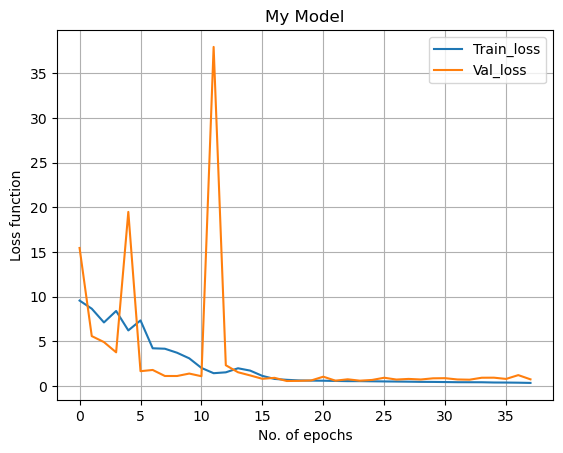

In [125]:
train_hist = torch.detach(torch.Tensor(train_losses)).numpy()
test_hist = torch.detach(torch.Tensor(val_losses)).numpy()

plt.plot(np.array(train_hist))
plt.plot(np.array(test_hist))

plt.xlabel("No. of epochs")
plt.ylabel('Loss function')
plt.legend(['Train_loss', 'Val_loss'], )
plt.title('My Model')
plt.grid()

In [29]:
model1 = torch.load('mymodel_256_bottleneck_balancing.pt')
# model.eval()

In [32]:
torch.manual_seed(78)
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score

# test_load_all = DataLoader(test_dataset, batch_size= len(ts_dloader.dataset), shuffle = False)
predictions = []
gt = []
val_corr= 0
val_losses = []
val_correct = []

model.eval()
with torch.no_grad():
      for b, (X_val, y_val) in enumerate(vl_dloader):
          # if b == max_tst_batch:
          #     break

          # Apply the model
          y_hat = model(X_val.cuda())

          # Tally the number of correct predictions
          predicted = torch.max(y_hat.data.cuda(), 1)[1]
          val_corr += (predicted == y_val.cuda()).sum()
        #   ts_loss = criterion(y_hat, y_test.cuda())
          # val_losses.append(ts_loss)
          val_correct.append(val_corr)
          predictions.append(predicted)
          gt.append(y_val.cuda())
          


In [33]:
gt_val = torch.cat([x for x in gt], dim=0)
gt_val = gt_val.cpu().numpy()

pred_val = torch.cat([x for x in predictions], dim=0)
pred_val = pred_val.cpu().numpy()

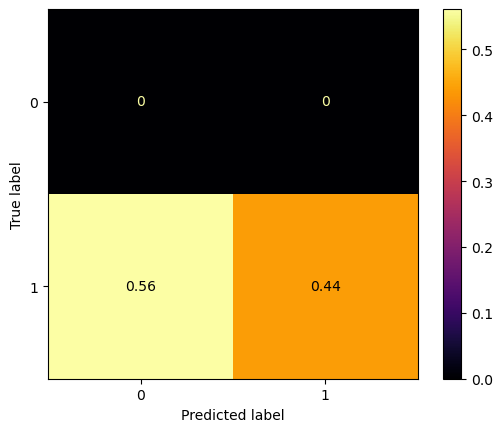

In [34]:
cm = confusion_matrix(pred_val, gt_val, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= np.array(['0','1']) )
disp.plot(cmap='inferno')

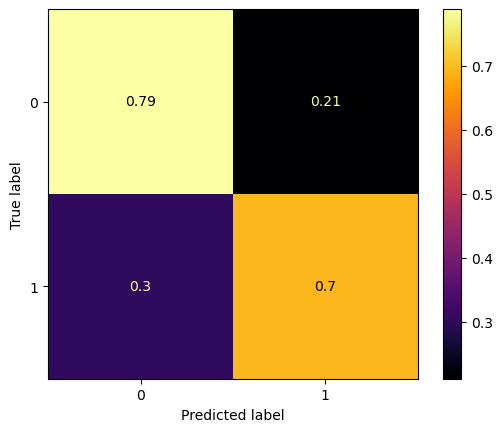

In [197]:
cm = confusion_matrix(pred_val, gt_val, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= np.array(['0','1']) )
disp.plot(cmap='inferno')

In [35]:
model.load_state_dict(torch.load("mymodel_256_bottleneck_balancing.pt"))


<All keys matched successfully>

In [87]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score

# test_load_all = DataLoader(test_dataset, batch_size= len(ts_dloader.dataset), shuffle = False)
predictions = []
gt = []
tst_corr= 0
test_losses = []
test_correct = []
model.eval()
with torch.no_grad():
      for b, (X_test, y_test) in enumerate(ts_dloader):
          # if b == max_tst_batch:
          #     break

          # Apply the model
          y_hat = model(X_test.cuda())

          # Tally the number of correct predictions
          predicted = torch.max(y_hat.data.cuda(), 1)[1] 
          tst_corr += (predicted == y_test.cuda()).sum()
        #   ts_loss = criterion(y_hat, y_test.cuda())
          # test_losses.append(ts_loss)
          test_correct.append(tst_corr)
          predictions.append(predicted)
          gt.append(y_test.cuda())
          


In [88]:
gt_test = torch.cat([x for x in gt], dim=0)
gt_test = gt_test.cpu().numpy()

pred_test = torch.cat([x for x in predictions], dim=0)
pred_test = pred_test.cpu().numpy()

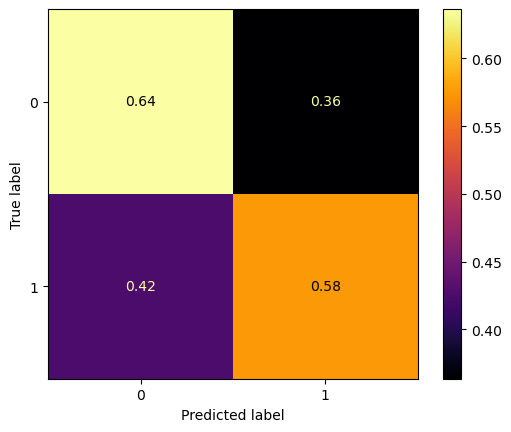

In [89]:
cm = confusion_matrix(pred_test, gt_test, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= np.array(['0','1']) )
disp.plot(cmap='inferno')

In [90]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

test_acc = accuracy_score(gt_test, pred_test)
test_acc

0.6134020618556701

# Monte Carlo Dropout (MC-Dropout)

In [13]:
def conv_bank_MCdrop(in_channels, out_channels):
    """_summary_

    Args:
        in_channels (_type_): _description_
        out_channels (_type_): _description_

    Returns:
        _type_: _description_
    """
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding='same'),
                         nn.Dropout2d(p=0.1),
                         nn.ReLU(),
                         
                         nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding='same'),
                         nn.Dropout2d(p=0.1),
                         nn.ReLU(),
                         
                         nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding='same'),
                         nn.Dropout2d(p=0.1),
                         nn.ReLU(),
                         
                         nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))

In [14]:
class LeNet_MC(nn.Module):
    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(LeNet_MC, self).__init__()
        
        self.bank1 = conv_bank_MCdrop(3, 64)
        self.bank2 = conv_bank_MCdrop(64, 128)
        self.bank3 = conv_bank_MCdrop(128, 256)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        # self.bn3 = nn.BatchNorm2d(256)
        # self.bank4 = conv_bank(256, 512)
        
        
        self.fc1 = nn.Linear(in_features=256*32*32, out_features=classes)
        # self.fc1 = nn.Linear(in_features=512*16*16, out_features=classes)

        # self.relu3 = nn.ReLU()
        # # initialize our softmax classifier
        # self.fc2 = nn.Linear(in_features=50, out_features=classes)
        self.drop = nn.Dropout(p = 0.1)
        self.logSoftmax = nn.LogSoftmax(dim=1)
        # self.output = nn.Linear(1)

        [nn.init.xavier_normal_(i.weight) for i in self.bank1 if isinstance(i, nn.Conv2d)]
        [nn.init.xavier_normal_(i.weight) for i in self.bank2 if isinstance(i, nn.Conv2d)]
        [nn.init.xavier_normal_(i.weight) for i in self.bank3 if isinstance(i, nn.Conv2d)]
        # [nn.init.xavier_normal_(i.weight) for i in self.bank4 if isinstance(i, nn.Conv2d)]
        nn.init.xavier_normal_(self.fc1.weight)

    def forward(self, x):
        # pass the input through our first set of CONV => RELU => POOL layers
        x = self.bn1(self.bank1(x))
        x = self.bn2(self.bank2(x))
        x = self.bank3(x)
        # x = self.bank4(x)

        x = self.drop(torch.flatten(x,1))
        x = self.fc1(x)
        # x = self.relu3(x)
        # x = self.fc2(x)
        output = self.logSoftmax(x)
        # output = x
        # return the output predictions
        return output


In [15]:
torch.manual_seed(78)
model_mc = LeNet_MC(numChannels=3, classes=2)

In [75]:
from torchinfo import summary
input_tensor = torch.randn(8, 3, 256, 256).float().cuda()  # Assuming 32x32 RGB images

# Forward pass through the model
summary(model_mc, input_size=(8, 3,  256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet_MC                                 [8, 2]                    --
├─Sequential: 1-1                        [8, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [8, 64, 256, 256]         1,792
│    └─Dropout2d: 2-2                    [8, 64, 256, 256]         --
│    └─ReLU: 2-3                         [8, 64, 256, 256]         --
│    └─Conv2d: 2-4                       [8, 64, 256, 256]         36,928
│    └─Dropout2d: 2-5                    [8, 64, 256, 256]         --
│    └─ReLU: 2-6                         [8, 64, 256, 256]         --
│    └─Conv2d: 2-7                       [8, 64, 256, 256]         36,928
│    └─Dropout2d: 2-8                    [8, 64, 256, 256]         --
│    └─ReLU: 2-9                         [8, 64, 256, 256]         --
│    └─MaxPool2d: 2-10                   [8, 64, 128, 128]         --
├─BatchNorm2d: 1-2                       [8, 64, 128, 128]         128
├─S

In [16]:
device = torch.device('cuda')
model_mc.to(device)
next(model_mc.parameters()).is_cuda
input = torch.randn(8, 3, 256, 256).float()
model_mc(input.cuda()).shape

torch.Size([8, 2])

In [17]:
torch.manual_seed(78)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(W).cuda())
# criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model_mc.parameters(), lr=0.001)

In [18]:
class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            torch.save(model_mc.state_dict(), 'mymodel_mc_256_bottleneck_balancing_correct.pt')
            print(f'Saving the best weights at validation loss: {self.min_validation_loss}\n\n')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
early_stopper = EarlyStopper(patience=50)

In [ ]:
torch.manual_seed(78)
epochs = 500

train_losses = []
val_losses = []

trn_accuracy = []
val_accuracy = []
device = 'cuda'

for epoch in range(epochs):
    # Training
    model_mc.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in tr_dloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_mc(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(tr_dloader)
    train_accuracy = 100.0 * train_correct / len(tr_dloader.dataset)

    train_losses.append(train_loss)
    trn_accuracy.append(train_accuracy)

    # Validation
    model_mc.eval()
    valid_loss = 0.0
    valid_correct = 0
    with torch.no_grad():
        for images, labels in vl_dloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_mc(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_correct += (predicted == labels).sum().item()

    valid_loss /= len(vl_dloader)
    valid_accuracy = 100.0 * valid_correct / len(vl_dloader.dataset)

    val_losses.append(valid_loss)
    val_accuracy.append(valid_accuracy)

    # Print progress
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    
    if early_stopper.early_stop(valid_loss):             
        break

In [24]:
model_mc.load_state_dict(torch.load("mymodel_mc_256_bottleneck_balancing_correct.pt"))


<All keys matched successfully>

In [25]:
torch.manual_seed(78)
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score

# test_load_all = DataLoader(test_dataset, batch_size= len(ts_dloader.dataset), shuffle = False)
predictions = []
gt = []
val_corr= 0
val_losses = []
val_correct = []
smx = []

model_mc.eval()
with torch.no_grad():
      for b, (X_val, y_val) in enumerate(vl_dloader):
          # if b == max_tst_batch:
          #     break

          # Apply the model
          y_hat = model_mc(X_val.cuda())
          smx.append(y_hat)

          # Tally the number of correct predictions
          predicted = torch.max(y_hat.data.cuda(), 1)[1]
          val_corr += (predicted == y_val.cuda()).sum()
        #   ts_loss = criterion(y_hat, y_test.cuda())
          # val_losses.append(ts_loss)
          val_correct.append(val_corr)
          predictions.append(predicted)
          gt.append(y_val.cuda())
          


In [ ]:
yarab  =  torch.cat([x for x in smx], dim=0)
yarab = torch.exp(yarab)
# yarab

In [27]:
gt_val = torch.cat([x for x in gt], dim=0)
gt_val = gt_val.cpu().numpy()

pred_val = torch.cat([x for x in predictions], dim=0)
pred_val = pred_val.cpu().numpy()

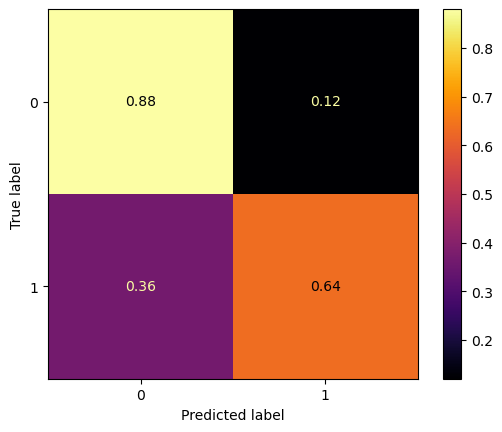

In [28]:
cm = confusion_matrix(pred_val, gt_val, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= np.array(['0','1']) )
disp.plot(cmap='inferno')

In [29]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

val_acc = accuracy_score(gt_val, pred_val)
val_acc

0.7295918367346939

In [73]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score

# test_load_all = DataLoader(test_dataset, batch_size= len(ts_dloader.dataset), shuffle = False)
predictions = []
gt = []
tst_corr= 0
test_losses = []
test_correct = []
test_smx = []

model_mc.eval()
with torch.no_grad():
      for b, (X_test, y_test) in enumerate(ts_dloader):
          # if b == max_tst_batch:
          #     break

          # Apply the model
          y_hat = model_mc(X_test.cuda())
          test_smx.append(y_hat)
          # Tally the number of correct predictions
          predicted = torch.max(y_hat.data.cuda(), 1)[1] 
          tst_corr += (predicted == y_test.cuda()).sum()
        #   ts_loss = criterion(y_hat, y_test.cuda())
          # test_losses.append(ts_loss)
          test_correct.append(tst_corr)
          predictions.append(predicted)
          gt.append(y_test.cuda())
          


In [74]:
gt_test = torch.cat([x for x in gt], dim=0)
gt_test = gt_test.cpu().numpy()

pred_test = torch.cat([x for x in predictions], dim=0)
pred_test = pred_test.cpu().numpy()

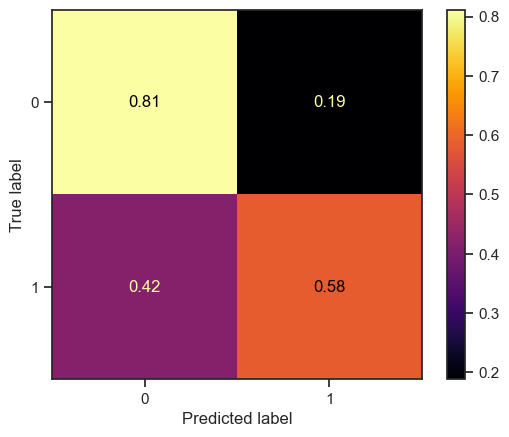

In [75]:
cm = confusion_matrix(pred_test, gt_test, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= np.array(['0','1']) )
disp.plot(cmap='inferno')

In [33]:
test_acc = accuracy_score(gt_test, pred_test)
test_acc

0.6649484536082474

# MC-Dropout (testing the code)

In [ ]:
import torch
import torch.nn as nn

# Assuming you have defined and instantiated your model
# model = YourModel()

# Loop through the layers of the model
for name, param in model_mc.named_parameters():
    # Check if the parameter requires gradients
    if not param.requires_grad:
        print(f"Parameter '{name}' is frozen")
    else:
        print(f"Parameter '{name}' is not frozen")


In [480]:
import torch
import torch.nn as nn

# Assuming you have defined and instantiated your model
# model = YourModel()

# Freeze all layers
import torch
import torch.nn as nn

# Assuming you have defined and instantiated your model
# model = YourModel()

# Freeze all layers
for param in model_mc.parameters():
    param.requires_grad = False

# Unfreeze dropout layers
for module in model_mc.children():
    for child in module.children():
        if isinstance(child, nn.Dropout2d):
            child.requires_grad_(True)

        # if isinstance(module, nn.Dropout2d):
            for param in child.parameters():
                param.requires_grad = True
                print('yes')



In [ ]:
from tqdm import tqdm

torch.manual_seed(78)
predictions = []
gt = []
tst_corr= 0
test_losses = []
test_correct = []

mc_acc = []

no_sampling = 1000


test_smx_nsamples = []
model_mc.eval()

for i in range(no_sampling):
  
  # model_mc.bn1.weight.requires_grad = False
  # model_mc.bn1.bias.requires_grad = False

  # model_mc.bn2.weight.requires_grad = False
  # model_mc.bn2.bias.requires_grad = False
  for param in model_mc.parameters():
    param.requires_grad = False

# Unfreeze dropout layers
  for module in model_mc.children():
      for child in module.children():
          if isinstance(child, nn.Dropout2d):
              child.train(True)
     
  model_mc.drop.train(True)
  # model_mc.bn3.weight.requires_grad = False
  # model_mc.bn3.bias.requires_grad = False

# model_mc.eval()
  # with torch.no_grad():
  for b, (X_test, y_test) in enumerate(ts_dloader):
      # if b == max_tst_batch:
      #     break

      # Apply the model
      y_hat = model_mc(X_test.cuda())

      # Tally the number of correct predictions
      predicted = torch.max(y_hat.data.cuda(), 1)[1] 
      tst_corr += (predicted == y_test.cuda()).sum()
    #   ts_loss = criterion(y_hat, y_test.cuda())
      # test_losses.append(ts_loss)
      test_correct.append(tst_corr)
      predictions.append(predicted)
      gt.append(y_test.cuda())
      test_smx_nsamples.append(y_hat)

  gt_test = torch.cat([x for x in gt], dim=0)
  gt_test = gt_test.cpu().numpy()

  pred_test = torch.cat([x for x in predictions], dim=0)
  pred_test = pred_test.cpu().numpy()

  test_acc = accuracy_score(gt_test, pred_test)

  predictions = []
  gt = []
  tst_corr= 0
  test_losses = []
  test_correct = []

  mc_acc.append(test_acc)


In [35]:
torch.manual_seed(78)
# predictions = []
# gt = []
# tst_corr= 0
# test_losses = []
# test_correct = []

# mc_acc = []

no_sampling = 1000


val_smx_nsamples = []
model_mc.eval()

for i in range(no_sampling):
  
  # model_mc.bn1.weight.requires_grad = False
  # model_mc.bn1.bias.requires_grad = False

  # model_mc.bn2.weight.requires_grad = False
  # model_mc.bn2.bias.requires_grad = False
  for param in model_mc.parameters():
    param.requires_grad = False

# Unfreeze dropout layers
  for module in model_mc.children():
      for child in module.children():
          if isinstance(child, nn.Dropout2d):
              child.train(True)
     
  model_mc.drop.train(True)
  # model_mc.bn3.weight.requires_grad = False
  # model_mc.bn3.bias.requires_grad = False

# model_mc.eval()
  # with torch.no_grad():
  for b, (X_val, y_val) in enumerate(vl_dloader):
      # if b == max_tst_batch:
      #     break

      # Apply the model
      y_hat = model_mc(X_val.cuda())

      # Tally the number of correct predictions
    #   predicted = torch.max(y_hat.data.cuda(), 1)[1] 
    #   tst_corr += (predicted == y_test.cuda()).sum()
    #   ts_loss = criterion(y_hat, y_test.cuda())
      # test_losses.append(ts_loss)
    #   test_correct.append(tst_corr)
    #   predictions.append(predicted)
    #   gt.append(y_test.cuda())
      val_smx_nsamples.append(y_hat)

#   gt_test = torch.cat([x for x in gt], dim=0)
#   gt_test = gt_test.cpu().numpy()

#   pred_test = torch.cat([x for x in predictions], dim=0)
#   pred_test = pred_test.cpu().numpy()

#   test_acc = accuracy_score(gt_test, pred_test)

#   predictions = []
#   gt = []
#   tst_corr= 0
#   test_losses = []
#   test_correct = []

#   mc_acc.append(test_acc)


In [38]:
val_smx_nos = torch.cat([x for x in val_smx_nsamples], dim=0)
# test_smx_nos = test_smx_nos.cpu().numpy()

val_smx_nos = val_smx_nos.view(1000, 196, 2)
val_smx_nos.shape

torch.Size([1000, 196, 2])

In [39]:
val_smx_nos = torch.Tensor(val_smx_nos)
torch.exp(val_smx_nos[:, 0,:])

tensor([[0.4653, 0.5347],
        [0.5172, 0.4828],
        [0.4809, 0.5191],
        ...,
        [0.4578, 0.5422],
        [0.5177, 0.4823],
        [0.3435, 0.6565]], device='cuda:0')

In [43]:
val_mc_std = val_smx_nos.std(dim=0)
test_mc_std = test_smx_nos.std(dim=0)
print(val_mc_std.shape, test_mc_std.shape)

torch.Size([196, 2]) torch.Size([194, 2])


In [33]:
test_smx_nos = torch.cat([x for x in test_smx_nsamples], dim=0)
# test_smx_nos = test_smx_nos.cpu().numpy()

test_smx_nos = test_smx_nos.view(1000, 194, 2)
test_smx_nos.shape

torch.Size([1000, 194, 2])

In [34]:
test_smx_nos = torch.Tensor(test_smx_nos)
torch.exp(test_smx_nos[:, 0,:])

tensor([[0.6736, 0.3264],
        [0.5375, 0.4625],
        [0.5963, 0.4037],
        ...,
        [0.4593, 0.5407],
        [0.4896, 0.5104],
        [0.6825, 0.3175]], device='cuda:0')

(array([  4.,  26.,  99., 187., 204., 188., 137.,  90.,  49.,  16.]),
 array([0.24041201, 0.29739904, 0.35438606, 0.41137308, 0.4683601 ,
        0.52534711, 0.58233416, 0.63932115, 0.6963082 , 0.75329518,
        0.81028223]),
 <BarContainer object of 10 artists>)

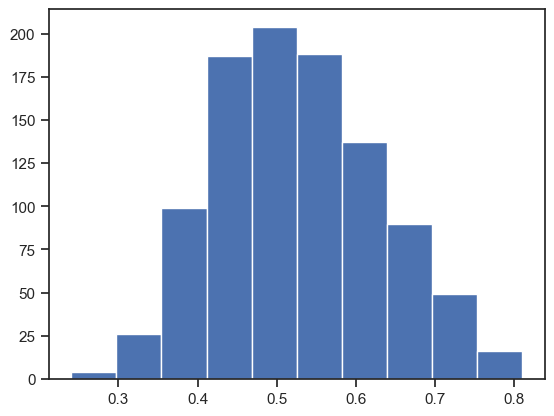

In [1624]:
class_0_std = torch.exp(test_smx_nos)[:,1,0]
plt.hist(class_0_std)

In [1627]:
+ 

tensor(0.2060)

In [1631]:
torch.exp(test_smx_nos)[:,2,1].std()

tensor(0.0860)

In [1633]:
torch.sigmoid(torch.Tensor(0.0806))

TypeError: new(): data must be a sequence (got float)

In [1630]:
torch.exp(test_smx_nos)[:,2,0].std() 

tensor(0.0860)

(array([ 16.,  49.,  90., 137., 188., 204., 187.,  99.,  26.,   4.]),
 array([0.1897178 , 0.24670482, 0.30369183, 0.36067885, 0.41766587,
        0.47465289, 0.53163987, 0.58862692, 0.64561391, 0.70260096,
        0.75958794]),
 <BarContainer object of 10 artists>)

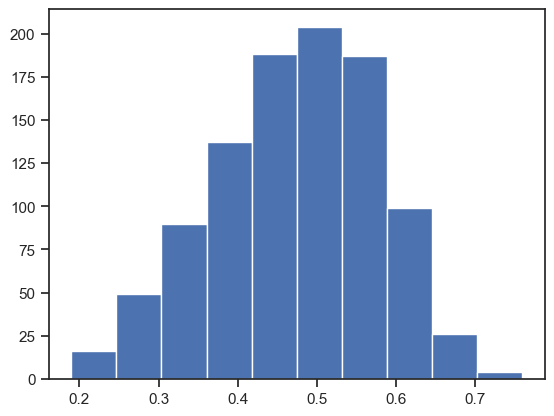

In [1626]:
class_1_std = torch.exp(test_smx_nos)[:,1,1]
plt.hist(class_1_std)

(array([53., 28., 15., 18., 21., 25., 19.,  9.,  5.,  1.]),
 array([0.        , 0.01863091, 0.03726181, 0.05589272, 0.07452363,
        0.09315453, 0.11178544, 0.13041635, 0.14904726, 0.16767816,
        0.18630907]),
 <BarContainer object of 10 artists>)

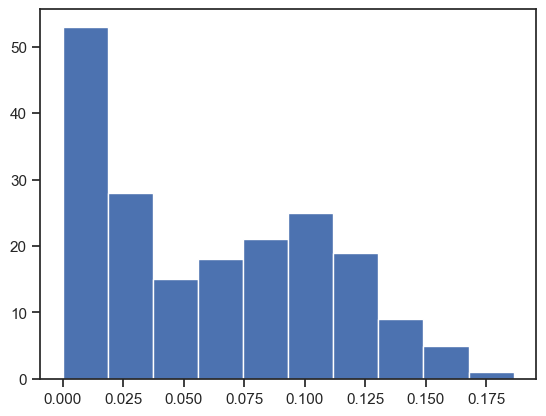

In [1623]:
plt.hist((torch.exp(test_smx_nos).std(dim=0))[:, 1])

In [ ]:
plt.hist(torch.exp(mean_1000runs[:, 1]))

In [1606]:
test_smx_nos[:,:, 1].shape

torch.Size([1000, 194])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Replace this with your actual data
softmax_values = test_smx_nos[:,:, 1].view(194, 1000)

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# X, Y, and Z coordinates for the 3D plot
x = np.arange(1, 1001)  # Replace 1001 with the number of runs + 1 (e.g., 1001 for 1000 runs)
y = np.arange(1, 195)   # Replace 195 with the number of images + 1 (e.g., 195 for 194 images)
X, Y = np.meshgrid(x, y)
Z = softmax_values.T   # Transpose the array to match the shape of X and Y

# Plot the 3D surface
ax.plot_surface(X.T, Y.T, Z, cmap='viridis')

# Customize the plot
ax.set_xlabel('Run')
ax.set_ylabel('Image')
ax.set_zlabel('Softmax Value')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace this with your actual data
# softmax_values = np.random.rand(194, 1000)

# Create a 3D histogram or 2D heatmap
plt.imshow(softmax_values, cmap='viridis', aspect='auto', extent=(1, 1001, 1, 195), origin='lower')

# Customize the plot
plt.xlabel('Run')
plt.ylabel('Image')
plt.title('Distribution of Softmax Values')
plt.colorbar(label='Softmax Value')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace this with your actual data
# softmax_values = np.random.rand(194, 1000)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(softmax_values, cmap='viridis', cbar_kws={'label': 'Softmax Value'}, xticklabels=100, yticklabels=50)
plt.xlabel('Run')
plt.ylabel('Image')
plt.title('Distribution of Softmax Values')

# Show the plot
plt.show()

In [1060]:
def add_black_box(image, box_size):
    h, w = image.shape[:2]
    center_h, center_w = h // 2, w // 2
    half_box_size = box_size // 2
    
    # Create a copy of the original image to avoid modifying it directly
    modified_image = np.copy(image)
    
    # Define the coordinates of the black box
    top = center_h - half_box_size
    bottom = center_h + half_box_size
    left = center_w - half_box_size
    right = center_w + half_box_size
    
    # Set the pixel values of the black box region to black (0)
    modified_image[top:bottom, left:right, :] = 0
    
    return modified_image


box_size = 100


In [976]:
ood = torch.randn((1, 3, 256, 256))

In [1186]:
torch.where(y_test == 1)

(tensor([ 17,  27,  28,  39,  41,  43,  45,  46,  47,  50,  53,  57,  62,  66,
          86,  88,  92,  94,  95,  96,  99, 101, 102, 103, 104, 105, 106, 107,
         108, 109, 112, 114, 116, 118, 119, 120, 121, 123, 124, 125, 127, 128,
         129, 130, 131, 132, 133, 134, 136, 138, 139, 140, 143, 145, 150, 154,
         155, 156, 158, 160, 161, 162, 164, 166, 167, 168, 169, 170, 172, 173,
         174, 175, 176, 177, 178, 179, 180, 185, 186, 187, 188, 189, 190, 191,
         192, 193]),)

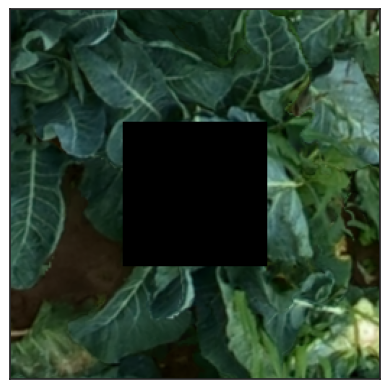

In [1559]:
img = X_test[172].view(256, 256, 3).numpy() 
# img = ood.view(256, 256, 3).numpy()
modified_image = add_black_box(img, box_size)
clipped_img = np.clip(modified_image, 0, 1)
# clipped_img = np.clip(img, 0, 1)
plt.xticks([])
plt.yticks([])


plt.imshow(clipped_img)
# clipped_img

In [1560]:
modified_image = torch.Tensor(modified_image)

In [1563]:
# For one sample
model_mc.eval()
mc_smx_one_sample = []
for i in range(1000):
  
  # model_mc.bn1.weight.requires_grad = False
  # model_mc.bn1.bias.requires_grad = False

  # model_mc.bn2.weight.requires_grad = False
  # model_mc.bn2.bias.requires_grad = False
#   for param in model_mc.parameters():
#     param.requires_grad = False

# Unfreeze dropout layers
  for module in model_mc.children():
      for child in module.children():
          if isinstance(child, nn.Dropout2d):
              child.train(True)
     
  model_mc.drop.train(True)
  

  # y_hat = model_mc(torch.unsqueeze(X_test[172].view(3, 256, 256), 0).cuda())
  # y_hat = model_mc((ood*(2)).cuda())
  # y_hat = model_mc(torch.unsqueeze(test_ood[0].view(3, 256, 256)*(1/3), 0).cuda())
  y_hat = model_mc(torch.unsqueeze(modified_image.view(3, 256, 256), 0).cuda())
  mc_smx_one_sample.append(y_hat)

In [1316]:
mc_smx_one = torch.cat([x for x in mc_smx_one_sample], dim=0)
mc_smx_one = torch.exp(mc_smx_one)
mc_smx_one = mc_smx_one.cpu().numpy()
mc_smx_one

array([[0.9945438, 0.0054562]], dtype=float32)

In [ ]:
import seaborn as sns

# mc_smx_one = torch.cat([x for x in mc_smx_one_sample], dim=0)
# mc_smx_one = torch.exp(mc_smx_one)
# mc_smx_one = mc_smx_one.cpu().numpy()

mc_smx_one_mod = torch.cat([x for x in mc_smx_one_sample], dim=0)
mc_smx_one_mod = torch.exp(mc_smx_one_mod )
mc_smx_one_mod = mc_smx_one_mod .cpu().numpy()




sns.set(style="ticks")
plt.figure(dpi=600)

bins = np.linspace(min(mc_smx_one[:,1]), max(mc_smx_one[:, 1]), 25)
sns.histplot(np.array(mc_smx_one[:, 1]), kde=True, bins=bins,)
plt.axvline(x = np.array(mc_smx_one[:, 1]).mean(), color = 'red', linestyle='dashed')

bins = np.linspace(min(mc_smx_one_mod[:,1]), max(mc_smx_one_mod[:, 1]), 25)
sns.histplot(np.array(mc_smx_one_mod[:, 1]), kde=True, bins=bins)
plt.axvline(x = np.array(mc_smx_one_mod[:, 1]).mean(), color = 'black', linestyle='dashed')
# plt.axvline(x = 0.56, color = 'Black', linestyle = 'dashed')
# plt.axvline(x = np.array(mc_acc).mean() - 2* np.array(mc_acc).std(), color = 'red', linestyle = 'dashed')
plt.xlabel(r'Probability $p$')
plt.ylabel('Count')
plt.legend([r'$P(\mathrm{y}=1| {X}_{test})$', r'Mean ($\mu$)', r'$P_{modified}(\mathrm{y}=1|X_{test})$', r'Mean ($\mu_{modified}$)'])
# plt.title('Probability Distribuition')
plt.grid()
# plt.savefig('Testing probability distribuition for black box addition_class_0_enhanced_sample172_again.png', format='png', dpi=600)

In [1576]:
mc_smx_one.std()

0.17422976

In [95]:
torch.exp(y_hat)

tensor([[0.2944, 0.7056],
        [0.4346, 0.5654]], device='cuda:0')

In [816]:
np.array(mc_acc).std()

0.018055955704457127

In [ ]:
plt.hist(np.array(mc_acc), bins=20)

In [813]:
np.median(np.array(mc_acc))

0.6494845360824743

In [814]:
q75, q25 = np.percentile(np.array(mc_acc), [75 ,25])
iqr = q75 - q25
print(iqr, q75, q25)

0.020618556701030966 0.6597938144329897 0.6391752577319587


In [ ]:
import seaborn as sns
sns.set(style="ticks")
plt.figure(dpi=600)

bins = np.linspace(min(mc_acc), max(mc_acc), 25)
sns.histplot(np.array(mc_acc), kde=True, bins=bins)
# plt.title(f'Empirical coverage distribuition after {r} runs')
plt.axvline(x = np.array(mc_acc).mean(), color = 'black', linestyle='dashed')
plt.axvline(x = np.array(mc_acc).mean() + 2* np.array(mc_acc).std(), color = 'red', linestyle = 'dashed')
plt.axvline(x = np.array(mc_acc).mean() - 2* np.array(mc_acc).std(), color = 'red', linestyle = 'dashed')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(['Accuracy distribuition', r'Mean($\mu$)', r'$\mu\pm2*\sigma$'])
# plt.title('Testing Accuracy distribuition for 1000 MC-Dropout forward runs')
plt.grid()
plt.savefig('Testing Accuracy distribuition for 1000 forward runs_correct_with_no_title.pdf', format='pdf', dpi=600)



In [590]:
test_acc_smx = torch.cat([x for x in test_smx], dim=0)
test_acc_smx = torch.exp(test_acc_smx)
test_acc_smx = test_acc_smx.cpu().numpy()
test_acc_smx

# Accuracy plot Vs. Threshold
acc_threshold = np.linspace(0, 1, 100)
acc_values = np.empty(len(acc_threshold))

for i, beta in enumerate(acc_threshold):
    acc_th_pred = [1 if j > beta else 0 for j in test_acc_smx[:, 1]]
    acc_th = accuracy_score(gt_test, acc_th_pred)
    acc_values[i] = acc_th
    
print(acc_values)

[0.44329897 0.44845361 0.45360825 0.45360825 0.45360825 0.45360825
 0.46391753 0.46391753 0.46391753 0.46907216 0.47938144 0.48453608
 0.48453608 0.49484536 0.5        0.50515464 0.51030928 0.51546392
 0.52061856 0.51546392 0.5257732  0.5257732  0.53092784 0.53608247
 0.54123711 0.55154639 0.55154639 0.55670103 0.55154639 0.56185567
 0.56701031 0.56701031 0.56701031 0.56701031 0.57731959 0.58247423
 0.58247423 0.59278351 0.59793814 0.61340206 0.6185567  0.62371134
 0.63402062 0.63917526 0.6443299  0.63917526 0.64948454 0.66494845
 0.66494845 0.66494845 0.66494845 0.66494845 0.65979381 0.67010309
 0.66494845 0.68041237 0.68556701 0.70103093 0.69587629 0.70103093
 0.69587629 0.70618557 0.68556701 0.67525773 0.65979381 0.65463918
 0.67010309 0.58247423 0.57731959 0.57216495 0.55670103 0.55154639
 0.55670103 0.55670103 0.55670103 0.55670103 0.55670103 0.55670103
 0.55670103 0.55670103 0.55670103 0.55670103 0.55670103 0.55670103
 0.55670103 0.55670103 0.55670103 0.55670103 0.55670103 0.5567

In [ ]:
import seaborn as sns
sns.set(style="ticks")
plt.figure(dpi=600)

plt.plot(acc_threshold, acc_values)
# plt.axhline(y = (acc_values).min(), color = 'black', linestyle='dashed')
# plt.axhline(y = (acc_values).max() , color = 'black', linestyle = 'dashed')
plt.axhline(y = accuracy_score(gt_test, pred_test), color = 'red', linestyle = 'dashed')
plt.xlabel(r'Threshold $\gamma$')
plt.ylabel('Testing Accuracy')
plt.legend(['Accuracy', 'ICP Accuracy'])
plt.title(r'Model Accuracy at Different $\gamma$s')
plt.grid()
plt.savefig('Model Accuracy for different thresholds_with_title.pdf', format='pdf', dpi=600)



In [60]:
predictions = []
gt = []
tst_corr= 0
test_losses = []
test_correct = []

mc_acc = []

no_sampling = 10
model_mc.train()
for i in range(no_sampling):
  
  model_mc.bn1.weight.requires_grad = False
  model_mc.bn1.bias.requires_grad = False

  model_mc.bn2.weight.requires_grad = False
  model_mc.bn2.bias.requires_grad = False

  model_mc.bn3.weight.requires_grad = False
  model_mc.bn3.bias.requires_grad = False

# model_mc.eval()
  # with torch.no_grad():
  for b, (X_test, y_test) in enumerate(ts_dloader):
      # if b == max_tst_batch:
      #     break

      # Apply the model
      y_hat = model_mc(X_test.cuda())

      # Tally the number of correct predictions
      predicted = torch.max(y_hat.data.cuda(), 1)[1] 
      tst_corr += (predicted == y_test.cuda()).sum()
    #   ts_loss = criterion(y_hat, y_test.cuda())
      # test_losses.append(ts_loss)
      test_correct.append(tst_corr)
      predictions.append(predicted)
      gt.append(y_test.cuda())

  gt_test = torch.cat([x for x in gt], dim=0)
  gt_test = gt_test.cpu().numpy()

  pred_test = torch.cat([x for x in predictions], dim=0)
  pred_test = pred_test.cpu().numpy()

  test_acc = accuracy_score(gt_test, pred_test)
  mc_acc.append(test_acc)


In [ ]:
torch.manual_seed(78)
epochs = 500

train_losses = []
val_losses = []

trn_accuracy = []
val_accuracy = []

predictions = []
gt = []
tst_corr= 0
test_losses = []
test_correct = []

mc_acc = []

for epoch in range(epochs):
    # Training
    model_mc.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in tr_dloader:
        # images = images.to(device)
        # labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_mc(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(tr_dloader)
    train_accuracy = 100.0 * train_correct / len(tr_dloader.dataset)

    train_losses.append(train_loss)
    trn_accuracy.append(train_accuracy)

    # testing
    

    no_sampling = 500
    for i in range(no_sampling):

        # model_mc.train()
        model_mc.bn1.weight.requires_grad = False
        model_mc.bn1.bias.requires_grad = False

        model_mc.bn2.weight.requires_grad = False
        model_mc.bn2.bias.requires_grad = False

        model_mc.bn3.weight.requires_grad = False
        model_mc.bn3.bias.requires_grad = False

        # model_mc.eval()
        # with torch.no_grad():
        for b, (X_test, y_test) in enumerate(ts_dloader):
            # if b == max_tst_batch:
            #     break

            # Apply the model
            y_hat = model_mc(X_test.cuda())

            # Tally the number of correct predictions
            predicted = torch.max(y_hat.data.cuda(), 1)[1] 
            tst_corr += (predicted == y_test.cuda()).sum()
            #   ts_loss = criterion(y_hat, y_test.cuda())
            # test_losses.append(ts_loss)
            test_correct.append(tst_corr)
            predictions.append(predicted)
            gt.append(y_test.cuda())

        gt_test = torch.cat([x for x in gt], dim=0)
        gt_test = gt_test.cpu().numpy()

        pred_test = torch.cat([x for x in predictions], dim=0)
        pred_test = pred_test.cpu().numpy()

        test_acc = accuracy_score(gt_test, pred_test)
        mc_acc.append(test_acc)


    # Print progress
    # print(f"Epoch [{epoch+1}/{epochs}], "
    #       f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
    #       f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.2f}%")
    
    if early_stopper.early_stop(valid_loss):             
        break

# Inductice Conformal Prediction (ICP)

In [ ]:
yarab  =  torch.cat([x for x in smx], dim=0)
yarab = torch.exp(yarab)
# yarab
smx_val = yarab

#in case of using MC-dropout standard deviations
# smx_val = val_mc_std
y_cp = torch.Tensor(pred_val).cuda()
gt_cp = torch.Tensor(gt_val).cuda()

y_cp = y_cp.to(int)
gt_cp = gt_cp.to(int)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Assuming you have the softmax output as a NumPy array
# softmax_output = np.array([[0.4, 0.6], [0.7, 0.3], ...])  # Shape: (196, 2)

# Assuming the true labels are binary (0 or 1)
true_labels = test_labels.cpu()  # Shape: (196,)

# Extract the predicted probabilities for both classes
positive_probs = test_smx[:, 1].cpu()
negative_probs = test_smx[:, 0].cpu()

# Calculate the true probabilities and the predicted probabilities for calibration curve
true_probs_positive, pred_probs_positive = calibration_curve(true_labels, test_scores.cpu(), n_bins=10)
true_probs_negative, pred_probs_negative = calibration_curve(true_labels, test_smx[:,1].cpu(), n_bins=10)

# Plot the calibration curve
plt.plot(pred_probs_positive, true_probs_positive, marker='o', linestyle='-', label='Positive Class')
plt.plot(pred_probs_negative, true_probs_negative, marker='o', linestyle='-', label='Negative Class')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot (Binary Classification)')
plt.legend()
plt.show()


In [ ]:
plt.scatter(test_smx[:, 1].cpu(), test_scores.cpu())

In [649]:
from sklearn.metrics import brier_score_loss

y_true = test_labels.cpu()  # True labels (0 or 1)
y_prob = test_smx[:, 1].cpu()  # Predicted probabilities

brier_score = brier_score_loss(y_true, y_prob)
print(f"Brier Score: {brier_score}")


Brier Score: 0.19707553922654664


In [ ]:
plt.hist(smx_val[:, 1].cpu())

In [43]:
n = 100
# idx = np.array([1] * n + [0] * (y_smx.shape[0]-n)) > 0
idx = np.array([1] * n + [0] * (smx_val.shape[0]-n)) > 0
np.random.shuffle(idx)
# cal_smx, test_smx = y_smx[idx,:], y_smx[~idx,:]
cal_smx, test_smx = smx_val[idx,:], smx_val[~idx,:]
cal_labels, test_labels = gt_cp[idx], gt_cp[~idx]
model_cal_pred, model_test_pred = y_cp[idx], y_cp[~idx]


cal_labels, test_labels = cal_labels.to(int), test_labels.to(int)
model_cal_pred, model_test_pred = model_cal_pred.to(int), model_test_pred.to(int)
X_cal, X_test = X_val[idx,:,:,:], X_val[~idx,:,:,:]

In [44]:
print(f'The shape of the claibration samples {X_cal.shape}, and the test samples {X_test.shape} and with dtype {X_cal.dtype}\n')
print(f'The shape of the claibration softmax {cal_smx.shape}, and the test softmax {test_smx.shape} and with dtype {cal_smx.dtype}\n')
print(f'The shape of the claibration labels {cal_labels.shape}, and the test labels {test_labels.shape} and with dtype {cal_labels.dtype}\n')

The shape of the claibration samples (100, 256, 256, 3), and the test samples (96, 256, 256, 3) and with dtype float64

The shape of the claibration softmax torch.Size([100, 2]), and the test softmax torch.Size([96, 2]) and with dtype torch.float32

The shape of the claibration labels torch.Size([100]), and the test labels torch.Size([96]) and with dtype torch.int64



In [49]:
alpha = 0.2

cal_scores = 1- cal_smx[np.arange(n), cal_labels]
# cal_scores = 1 - np.abs((cal_smx[:, 0].cpu() - cal_smx[:, 1].cpu()))
# cal_scores = 1 - cal_smx[:, 0]
# cal_scores = torch.amax(cal_smx, dim=1)
# cal_scores = np.abs((cal_smx[:, 0].cpu() - cal_smx[:, 1].cpu()))
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores.cpu(), q_level, method='higher')
prediction_sets = test_smx >= (1-qhat) 
# prediction_sets = test_smx >= (1-qhat) 
prediction_sets.shape

torch.Size([96, 2])

In [50]:
cal_scores

tensor([0.3426, 0.7224, 0.0407, 0.5118, 0.1926, 0.4929, 0.5185, 0.6659, 0.6168,
        0.5295, 0.1879, 0.2479, 0.6222, 0.2758, 0.0079, 0.1487, 0.3303, 0.7847,
        0.0217, 0.4460, 0.1785, 0.1011, 0.2821, 0.1135, 0.1258, 0.6220, 0.0898,
        0.6725, 0.4927, 0.2806, 0.5231, 0.1335, 0.4063, 0.5233, 0.3453, 0.6635,
        0.1332, 0.2651, 0.1427, 0.1675, 0.3165, 0.5004, 0.4600, 0.3950, 0.3656,
        0.3148, 0.3273, 0.6747, 0.3253, 0.3239, 0.3172, 0.6855, 0.6729, 0.3253,
        0.3253, 0.3356, 0.3253, 0.3253, 0.5623, 0.3896, 0.3253, 0.3253, 0.2840,
        0.3964, 0.3244, 0.2959, 0.7107, 0.3253, 0.3246, 0.3253, 0.3253, 0.3316,
        0.3189, 0.4198, 0.5928, 0.4576, 0.3253, 0.6036, 0.3879, 0.3253, 0.6806,
        0.3308, 0.6220, 0.5262, 0.3253, 0.3253, 0.5298, 0.3253, 0.3303, 0.3253,
        0.3253, 0.4698, 0.4410, 0.3253, 0.3253, 0.4724, 0.4689, 0.5505, 0.3253,
        0.3197], device='cuda:0')

In [76]:
q_level

0.81

In [77]:
qhat

0.9955983

In [ ]:
prediction_sets

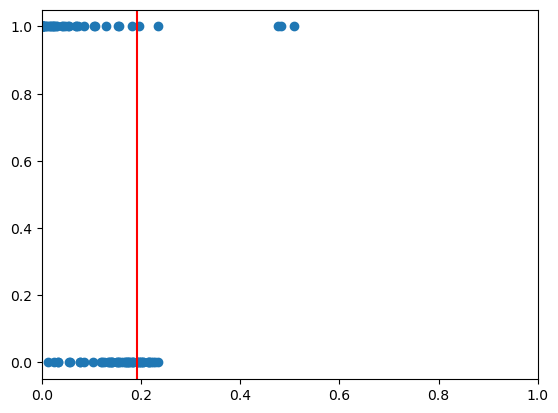

In [69]:
bins = np.linspace(0, 1.0, 100)
plt.scatter(cal_scores.cpu(), cal_labels.cpu())
plt.xlim(left=0 ,right=1)
plt.axvline(x=qhat, color='r')

In [1367]:
1-qhat

0.4701688885688782

In [674]:
# test_scores = (1 - test_smx[np.arange(96), test_labels])
# len(test_scores)

96

In [51]:
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), test_labels]
mean_empirical_coverage = empirical_coverage.sum()/len(empirical_coverage)
print(f"The empirical coverage is: {mean_empirical_coverage}")

The empirical coverage is: 0.75


In [732]:
prediction_sets

tensor([[ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, 

In [733]:
prediction_sets[np.arange(prediction_sets.shape[0]), test_labels]
prediction_sets

tensor([[ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True, False],
        [ True,  True],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, 

In [52]:
n = 100
alpha = 0.1
r = 1000
final_empirical_coverage = []

def cp_check(n = None, alpha = 0.1, r = 1000):
    """_summary_

    Args:
        n (_type_, optional): _description_. Defaults to None.
        alpha (float, optional): _description_. Defaults to 0.1.
        r (int, optional): _description_. Defaults to 1000.

    Returns:
        _type_: _description_
    """
    for i in range(r):

        idx = np.array([1] * n + [0] * (smx_val.shape[0]-n)) > 0
        np.random.shuffle(idx)
        # cal_smx, test_smx = y_smx[idx,:], y_smx[~idx,:]
        cal_smx, test_smx = smx_val[idx,:], smx_val[~idx,:]
        cal_labels, test_labels = gt_cp[idx], gt_cp[~idx]
        model_cal_pred, model_test_pred = y_cp[idx], y_cp[~idx]


        cal_labels, test_labels = cal_labels.to(int), test_labels.to(int)
        model_cal_pred, model_test_pred = model_cal_pred.to(int), model_test_pred.to(int)
        # X_cal, X_test = X_val[idx,:,:,:], X_val[~idx,:,:,:]

        # X_cal = torch.Tensor(X_cal)
        # X_test = torch.Tensor(X_test)

        # cal_smx = torch.Tensor(cal_smx)
        # test_smx = torch.Tensor(test_smx)

        # cal_labels = torch.Tensor(cal_labels)
        # test_labels = torch.Tensor(test_labels)

        # cal_labels = cal_labels.int()
        # test_labels = test_labels.int()

        cal_scores = 1 - cal_smx[np.arange(n), cal_labels]
        # cal_scores = np.abs((cal_smx[np.arange(n), cal_labels[:, 1]]) - (cal_smx[np.arange(n), cal_labels[:, 0]]))
        q_level = np.ceil((n+1)*(1-alpha))/n
        qhat = np.quantile(cal_scores.cpu(), q_level, method='higher')
        prediction_sets = test_smx >= (1-qhat) 


        empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), test_labels]
        mean_empirical_coverage = empirical_coverage.sum()/len(empirical_coverage)

        final_empirical_coverage.append(mean_empirical_coverage)

    return final_empirical_coverage 

final_empirical_coverage = cp_check(n=100, alpha=0.2, r=1000)   

print(f'The mean empirical coverage after: {r} different data splits is: {sum(final_empirical_coverage)/len(final_empirical_coverage)}')    

The mean empirical coverage after: 1000 different data splits is: 0.8123849034309387


In [54]:
final_empirical_coverage = [x.cpu() for x in final_empirical_coverage]
# final_empirical_coverage

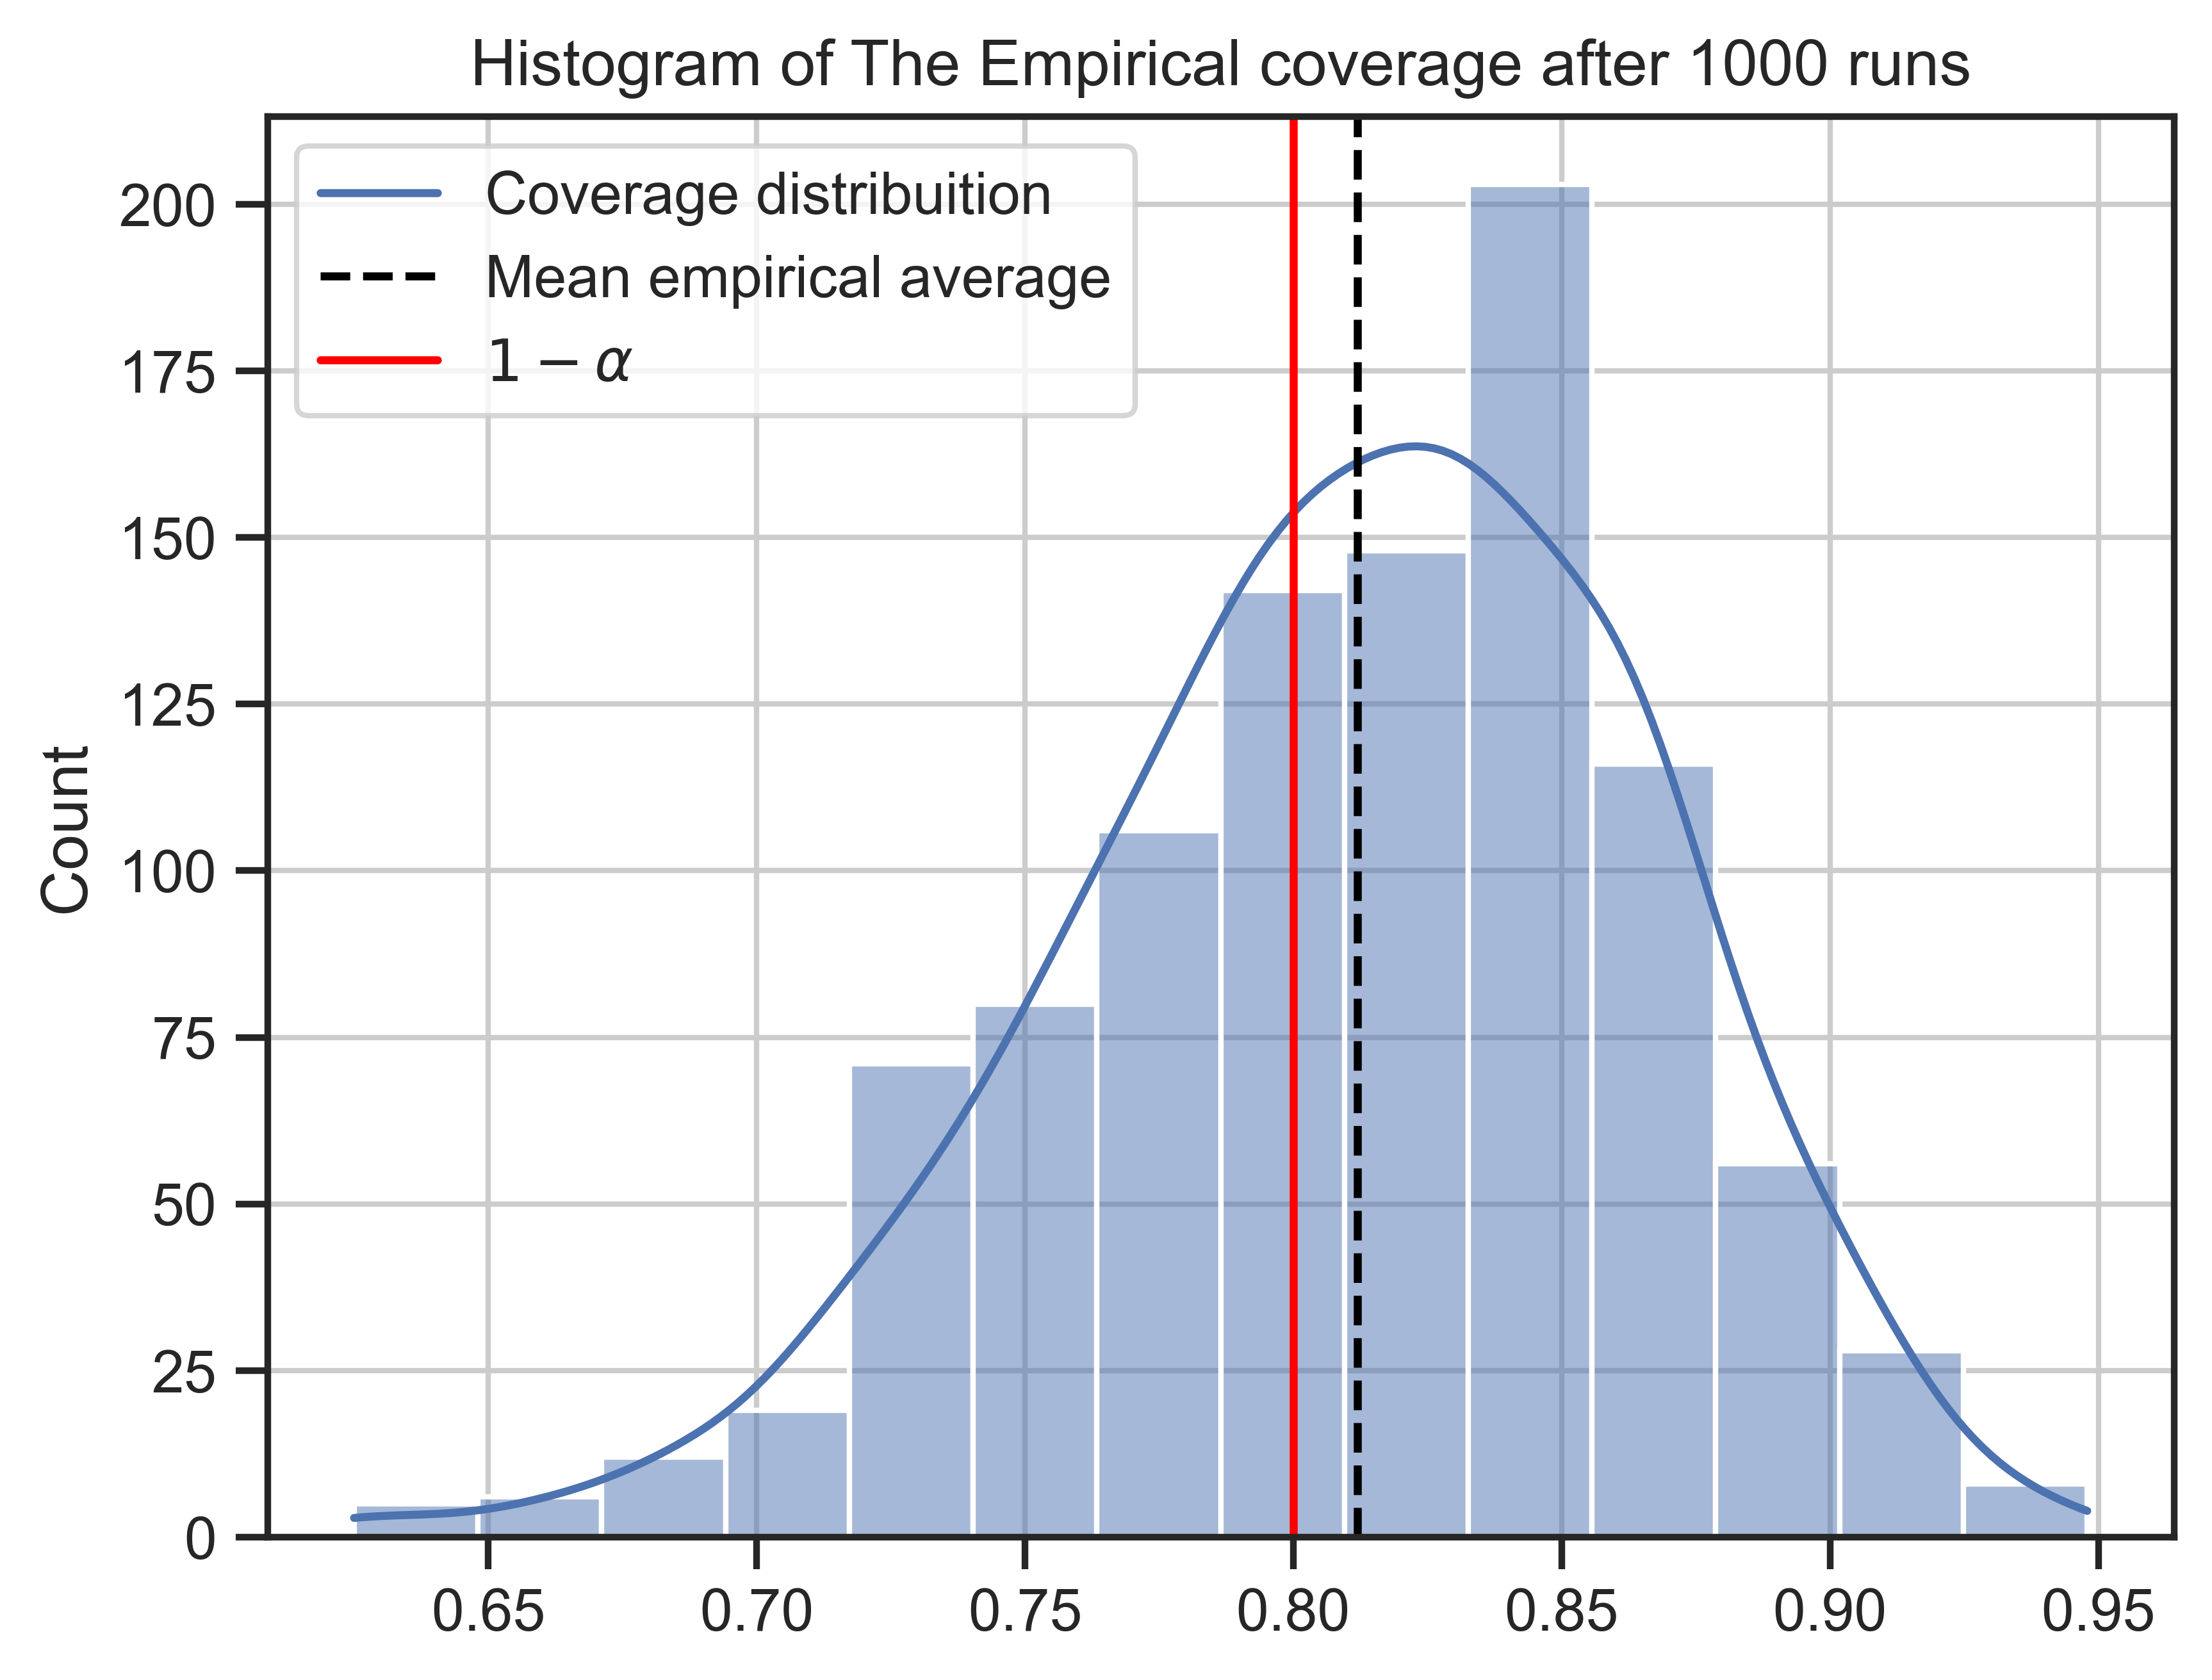

In [71]:
import seaborn as sns
sns.set(style="ticks")
plt.figure(dpi=600)

bins = np.linspace(min(final_empirical_coverage), max(final_empirical_coverage), 15)
sns.histplot(np.array(final_empirical_coverage), kde=True, bins=bins)
plt.title(f'Histogram of The Empirical coverage after {r} runs')
plt.axvline(x = 0.812, color = 'black', linestyle='dashed')
plt.axvline(x = 0.8, color = 'red', linestyle = 'solid')
plt.legend(['Coverage distribuition','Mean empirical average', r'$1-\alpha$'])
plt.grid()
# plt.savefig('Empirical_Coverage_dist_1000_runs_alpha_0.2_MCmodel.pdf', format='pdf', dpi=600)



In [ ]:
label_strings = np.array(['no-harvest', 'harvest'])

for i in range(test_labels.shape[0]):
    normalized_image = X_test[i]

    # Clip the data to ensure it falls within the valid range
    clipped_image = np.clip(normalized_image, 0, 1)

    prediction_set = test_smx[i] >  1-qhat

    plt.figure()
    plt.imshow(clipped_image)
    plt.axis('off')
    plt.show()
    if len(prediction_set) == 0:
        print(f'{150 *"_"}')
        print(f"The prediction set for image {i} is: [], and the true label is {test_labels[i, 1]}, and model's prediction is {test_labels[i, 0]}\n")
        print(f"The Softmax score for class 0: {test_smx[i, 0]}, and Softmax score for class 1: {test_smx[i, 1]}")
        print(f'{150 *"_"}') 
    else:
        print(f'{150 *"_"}')   
        print(f"The prediction set for image {i} is: {list(label_strings[prediction_set.cpu()])}, the true label is {test_labels[i].cpu()}, and model's prediction is {model_test_pred[i].cpu()}\n")
        print(f"The Softmax score for class 0: {test_smx[i, 0].cpu()}, and Softmax score for class 1: {test_smx[i, 1].cpu()}")
        print(f'{150 *"_"}') 

# ICP_testing

In [76]:
# Needed data for testing
temp  =  torch.cat([x for x in test_smx], dim=0)
temp = torch.exp(temp)

test_smx = temp

y_cp_test = torch.Tensor(pred_test).cuda()
gt_cp_test = torch.Tensor(gt_test).cuda()

y_cp_test = y_cp_test.to(int)
gt_cp_test = gt_cp_test.to(int)

print(len(test_smx), len(y_cp_test), len(gt_cp_test))

194 194 194


In [92]:
# X_cal = torch.Tensor(X_cal)
X_final = X_test

# cal_smx = torch.Tensor(cal_smx)
# test_smx = torch.Tensor(test_smx)

# cal_smx = torch.Tensor(cal_smx)
test_final_smx = test_smx

# cal_labels = torch.Tensor(cal_labels)
test_final_labels = gt_cp_test
model_final_test_pred = y_cp_test

# cal_labels = cal_labels.int()
# test_final_labels = test_final_labels.int()


# print(f'The shape of the claibration samples {X_cal.shape}, and the test samples {X_test.shape} and with dtype {X_cal.dtype}\n')
# print(f'The shape of the claibration softmax {cal_smx.shape}, and the test softmax {test_smx.shape} and with dtype {cal_smx.dtype}\n')
# print(f'The shape of the claibration labels {cal_labels.shape}, and the test labels {test_labels.shape} and with dtype {cal_labels.dtype}\n')

In [93]:
X_final.shape

(194, 256, 256, 3)

In [94]:
alpha = 0.2
n = len(y_cp)

cal_scores = 1 - smx_val[np.arange(n), gt_cp]
# cal_scores = 1 - cal_smx[:, 0]
# cal_scores = torch.amax(cal_smx, dim=1)
# cal_scores = np.abs((cal_smx[np.arange(n), cal_labels[:, 1]]) - (cal_smx[np.arange(n), cal_labels[:, 0]]))
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores.cpu(), q_level, method='higher')
prediction_sets = test_final_smx >= (1-qhat) 
# prediction_sets = test_smx >= (1-qhat) 
prediction_sets.shape

torch.Size([194, 2])

In [1502]:
q_level

0.8061224489795918

In [1503]:
qhat

0.5641619

In [1490]:
1-qhat

0.43583810329437256

In [95]:
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), test_final_labels]
mean_empirical_coverage = empirical_coverage.sum()/len(empirical_coverage)
print(f"The empirical coverage is: {mean_empirical_coverage}")

The empirical coverage is: 0.7525773048400879


In [ ]:
label_strings = np.array(['no-harvest', 'harvest'])
pred_set = []
output_set = []

y_cp_true = []
y_cp_pred = []

y_cp_double = []
y_cp_double_class_true = []
y_cp_double_class_pred = []
for i in range(test_final_labels.shape[0]):
    normalized_image = X_final[i]

    # Clip the data to ensure it falls within the valid range
    clipped_image = np.clip(normalized_image, 0, 1)

    prediction_set = test_final_smx[i] >  1-qhat

    plt.figure()
    plt.imshow(clipped_image)
    plt.axis('off')
    plt.show()
    if  sum(prediction_set) == 0:
        print(f'{150 *"_"}')
        print(f"The prediction set for image {i} is: [], and the true label is {test_final_labels[i, 1]}, and model's prediction is {test_final_labels[i, 0]}\n")
        print(f"The Softmax score for class 0: {test_final_smx[i, 0]}, and Softmax score for class 1: {test_final_smx[i, 1]}")
        print(f'{150 *"_"}')
        pred_set.append(prediction_set) 
    else:
        print(f'{150 *"_"}')   
        print(f"The prediction set for image {i} is: {list(label_strings[prediction_set.cpu()])}, the true label is {test_final_labels[i]}, and model's prediction is {model_final_test_pred[i]}\n")
        print(f"The Softmax score for class 0: {test_final_smx[i, 0]}, and Softmax score for class 1: {test_final_smx[i, 1]}")
        print(f'{150 *"_"}')
        # output_set.append(list(label_strings[prediction_set]))
        pred_set.append(prediction_set)

        if sum(prediction_set) == 1:
            y_cp_true.append(test_final_labels[i])
            y_cp_pred.append(model_final_test_pred[i])
            output_set.append(list(label_strings[prediction_set.cpu()]))

        elif sum(prediction_set) > 1:
            y_cp_double_class_true.append(test_final_labels[i])
            y_cp_double_class_pred.append(model_final_test_pred[i])
            y_cp_double.append(prediction_set.cpu())   
            


In [97]:
single_set = 0
double_set = 0
empty_set = 0

for i in pred_set:
    if sum(i) == 1:
        single_set += 1
    elif sum(i)  > 1:
        double_set += 1
    else:    
        empty_set += 1

print(f'Number of Single output sets {single_set},\n Double output sets {double_set},\n Empty sets {empty_set}')        

Number of Single output sets 160,
 Double output sets 34,
 Empty sets 0


In [98]:
correct_single_noh = 0
correct_single_h = 0

for i, pred_label in enumerate(y_cp_pred):
    
    # if sum(pred_set[i]) == 1:
    pred_label = pred_label.item()
    decision = output_set[i]
    y_cp_true_data = y_cp_true[i].item()

    # print(i, pred_label, decision, y_cp_true_data)

    if ((pred_label == 1) and (decision == ['harvest']) and (y_cp_true_data == 1)) :
        correct_single_h += 1
        
    elif ((pred_label == 0) and (decision == ['no-harvest']) and (y_cp_true_data == 0)) :
        correct_single_noh +=1

    # if ((pred_label == 1) and (decision == ['no-harvest']) and (y_cp_true_data == 0)):
        
    #     print('strange', i)

print(correct_single_noh, correct_single_h, correct_single_h + correct_single_noh)         

47 65 112


In [99]:
correct_double_set = 0

for i in range(len(y_cp_double)):
    if (y_cp_double_class_pred[i] == y_cp_double_class_true[i]):
        correct_double_set += 1

print(correct_double_set)        

17


In [806]:
(112/194)+(17/194)

0.6649484536082474

In [100]:
alpha_test = np.linspace(0.1, 1, 100)
# alpha_test = np.arange(0.1, 1.0, 0.1)

double_set_counter = 0
single_set_counter = 0
empty_set_counter = 0

double_pred_sets = np.zeros(len(alpha_test))
single_pred_sets = np.zeros(len(alpha_test))
empty_pred_sets = np.zeros(len(alpha_test))

pred_set_alphas = []
output_set_alphas = []

y_cp_true_temp = []
y_cp_pred_temp = []

y_cp_double_alphas = []
y_cp_double_class_true_temp = []
y_cp_double_class_pred_temp = []

acc_alpha = np.zeros(len(alpha_test))

for i, alpha in enumerate(alpha_test):
    
    n = len(y_cp)

    cal_scores = 1 - smx_val[np.arange(n), gt_cp]
    # cal_scores = 1 - cal_smx[:, 0]
    # cal_scores = torch.amax(cal_smx, dim=1)
    # cal_scores = np.abs((cal_smx[np.arange(n), cal_labels[:, 1]]) - (cal_smx[np.arange(n), cal_labels[:, 0]]))
    q_level = np.ceil((n+1)*(1-alpha))/n
    qhat = np.quantile(cal_scores.cpu(), q_level, method='higher')
    prediction_sets = test_final_smx >= (1-qhat) 

    for j, pred_set in enumerate(prediction_sets):

        if sum(pred_set) == 2:
            double_set_counter +=1
            double_pred_sets[i] = double_set_counter
            y_cp_double_class_true_temp.append(test_final_labels[j].cpu())
            y_cp_double_class_pred_temp.append(model_final_test_pred[j].cpu())
             

        elif sum(pred_set) == 1:
            single_set_counter +=1
            single_pred_sets[i] = single_set_counter
            y_cp_true_temp.append(test_final_labels[j].cpu())
            y_cp_pred_temp.append(model_final_test_pred[j].cpu())
            

           

        else:
            empty_set_counter += 1
            empty_pred_sets[i] = empty_set_counter

    # print(double_set_counter, single_set_counter)    
    # print(len(y_cp_double_class_true_temp), len(y_cp_true_temp))

    sing_corr_temp = accuracy_score(y_cp_true_temp, y_cp_pred_temp)
    double_corr_temp = accuracy_score(y_cp_double_class_true_temp, y_cp_double_class_pred_temp)
    # print(sing_corr_temp, double_corr_temp)

    # The problem is that we are calc. the accuracy at each j of them, but we needed to be in each alpha

    total_acc = (single_set_counter/186) *(sing_corr_temp) + (double_set_counter/186)*(double_corr_temp)
    acc_alpha[i] = total_acc
    # print(total_acc)          
    # break
    double_set_counter = 0
    single_set_counter = 0
    empty_set_counter = 0

    y_cp_true_temp = []
    y_cp_pred_temp = []

    y_cp_double_class_true_temp = []
    y_cp_double_class_pred_temp = []

c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\midok\anaconda3\envs\pyt_gpu\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret

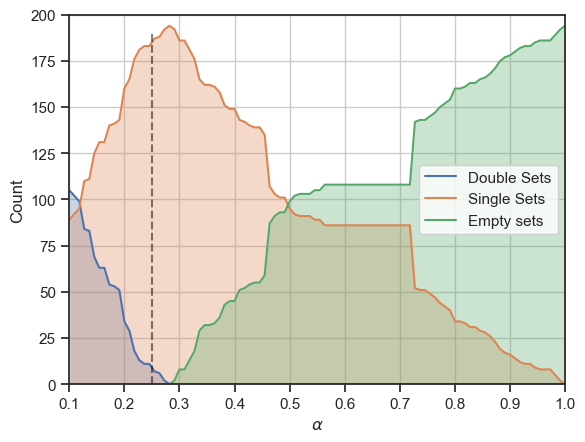

In [103]:
fig, ax = plt.subplots()


ax.plot(alpha_test, double_pred_sets, label= 'Double Sets')
ax.fill_between(alpha_test, double_pred_sets, alpha=0.3)

ax.plot(alpha_test, single_pred_sets, label='Single Sets')
ax.fill_between(alpha_test, single_pred_sets, alpha=0.3)

ax.plot(alpha_test, empty_pred_sets, label='Empty sets')
ax.fill_between(alpha_test, empty_pred_sets, alpha=0.3)

# Set labels and title
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Count')
# ax.set_title('ICP sensitivity analysis with different alphas ')

# Add a legend
ax.legend()
ax.grid()
ax.set_xlim((0.1, 1))
ax.set_ylim((0, 200))
ax.vlines(x = 0.25,  ymin=0, ymax=190, colors='black', linestyles='dashed', alpha=0.5)
plt.savefig('ICP_sens_analysis.png', format='png', dpi=600)

# # Display the plot
# plt.show()
# # Display the plot
plt.savefig(r'E:\Ph.D\Publications\Workshops\Inductive_Conformal_Prediction_ICCV2023\Images\Mutual_interaction\ICP_sens_analysis_my_model_without_title.png', format='png', dpi=600)


In [81]:
sane_val_test = np.concatenate([smx_val.cpu(), test_final_smx.cpu()], axis = 0)

sane_val_test.shape

(390, 2)

In [82]:
y_val_test = np.concatenate([gt_cp.cpu(), gt_cp_test.cpu()], axis = 0)
y_val_test.shape

(390,)

In [83]:
n = 196
alpha = 0.1
r = 1000
final_empirical_coverage = []

def cp_check(n = None, alpha = 0.2, r = 1000):
    for i in range(r):

        idx = np.array([1] * n + [0] * (sane_val_test.shape[0]-n)) > 0
        np.random.shuffle(idx)
        # cal_smx, test_smx = y_smx[idx,:], y_smx[~idx,:]
        cal_smx, test_smx = sane_val_test[idx,:], sane_val_test[~idx,:]
        cal_labels, test_labels = y_val_test[idx], y_val_test[~idx]
        # X_cal, X_test = X[idx,:,:,:], X[~idx,:,:,:]

        # X_cal = torch.Tensor(X_cal)
        # X_test = torch.Tensor(X_test)

        cal_smx = torch.Tensor(cal_smx)
        test_smx = torch.Tensor(test_smx)

        cal_labels = torch.Tensor(cal_labels)
        test_labels = torch.Tensor(test_labels)

        cal_labels = cal_labels.int()
        test_labels = test_labels.int()

        cal_scores = 1 - cal_smx[np.arange(n), cal_labels]
        # cal_scores = np.abs((cal_smx[np.arange(n), cal_labels[:, 1]]) - (cal_smx[np.arange(n), cal_labels[:, 0]]))
        q_level = np.ceil((n+1)*(1-alpha))/n
        qhat = np.quantile(cal_scores, q_level, method='higher')
        prediction_sets = test_smx >= (1-qhat) 


        empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]), test_labels]
        mean_empirical_coverage = empirical_coverage.sum()/len(empirical_coverage)

        final_empirical_coverage.append(mean_empirical_coverage)
        print(i)

    return final_empirical_coverage

final_empirical_coverage = cp_check(n=196, alpha=0.2, r=1000)   

print(f'The mean empirical coverage after: {r} different data splits is: {sum(final_empirical_coverage)/len(final_empirical_coverage)}')    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

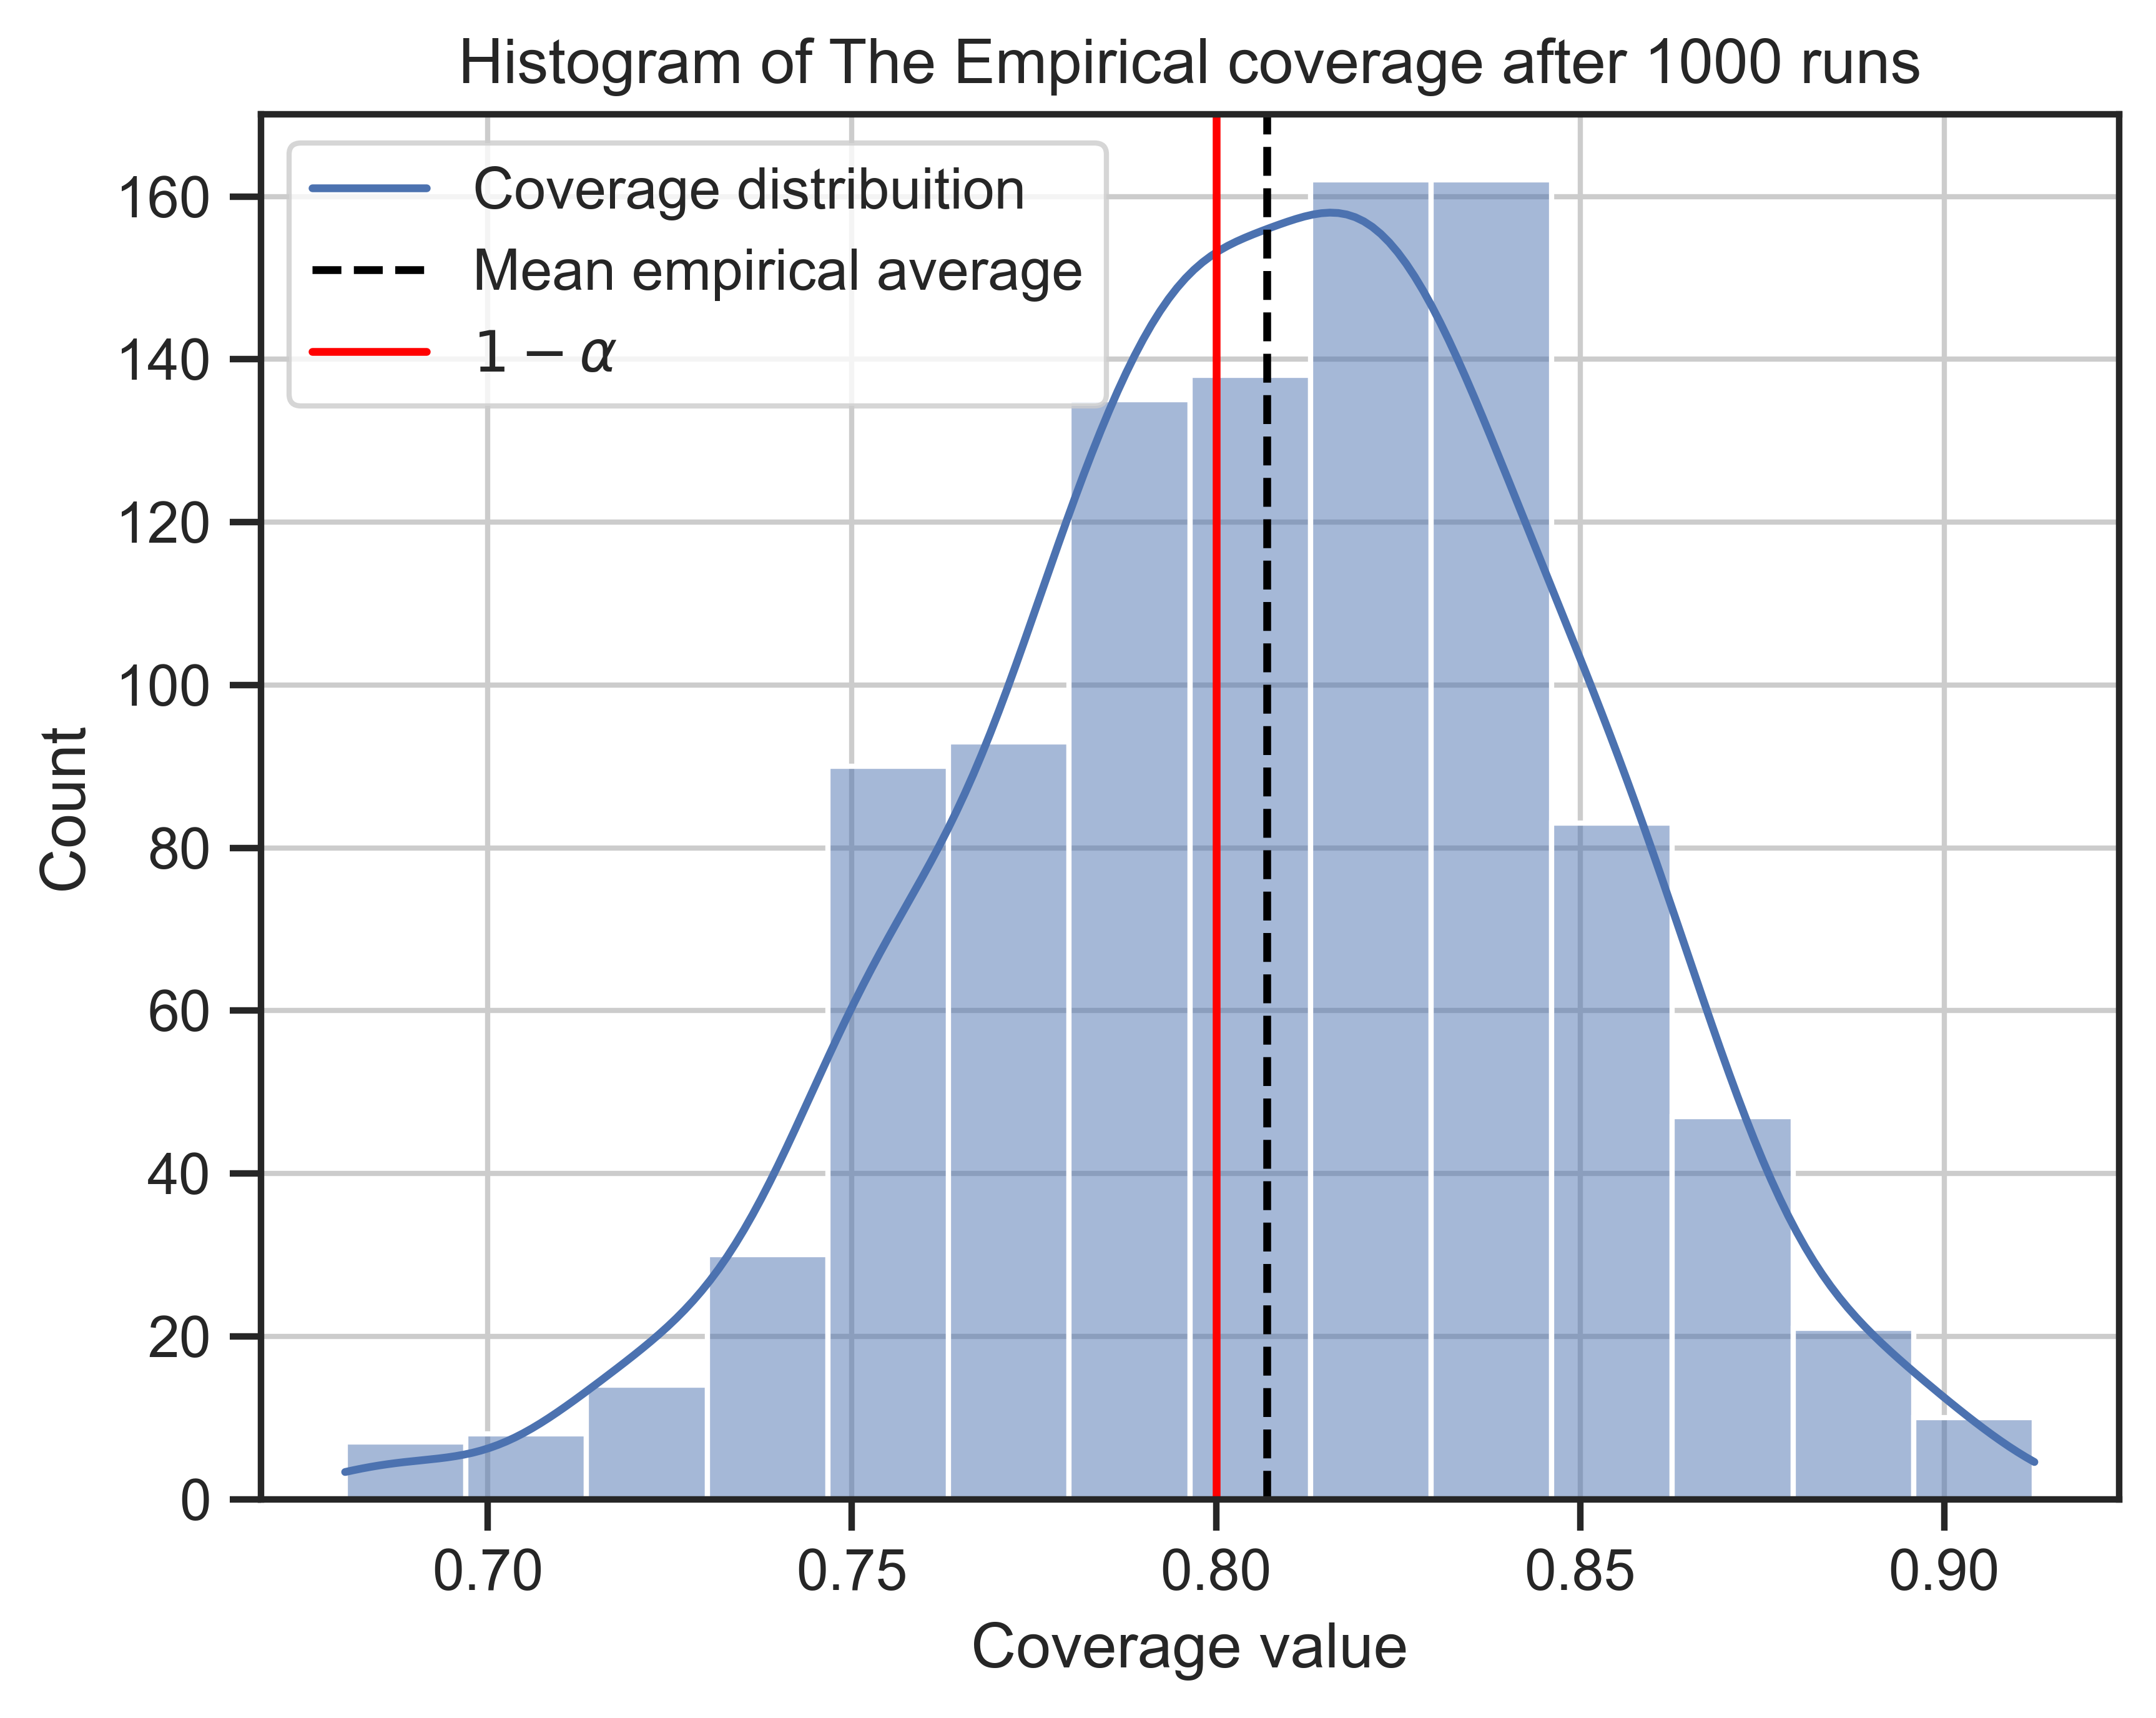

In [807]:
import seaborn as sns
sns.set(style="ticks")
plt.figure(dpi=600)

bins = np.linspace(min(final_empirical_coverage), max(final_empirical_coverage), 15)
sns.histplot(np.array(final_empirical_coverage), kde=True, bins=bins)
# plt.title(f'Histogram of The Empirical coverage after {r} runs')
plt.axvline(x = 0.807, color = 'black', linestyle='dashed')
plt.axvline(x = 0.8, color = 'red', linestyle = 'solid')
plt.legend(['Coverage distribuition','Mean empirical average', r'$1-\alpha$'])
plt.xlabel('Coverage value')
plt.grid()
plt.savefig('Empirical_Coverage_dist_1000_runs_alpha_0.2_mymodel_final_testing_196calpoints.pdf', format='pdf', dpi=600)

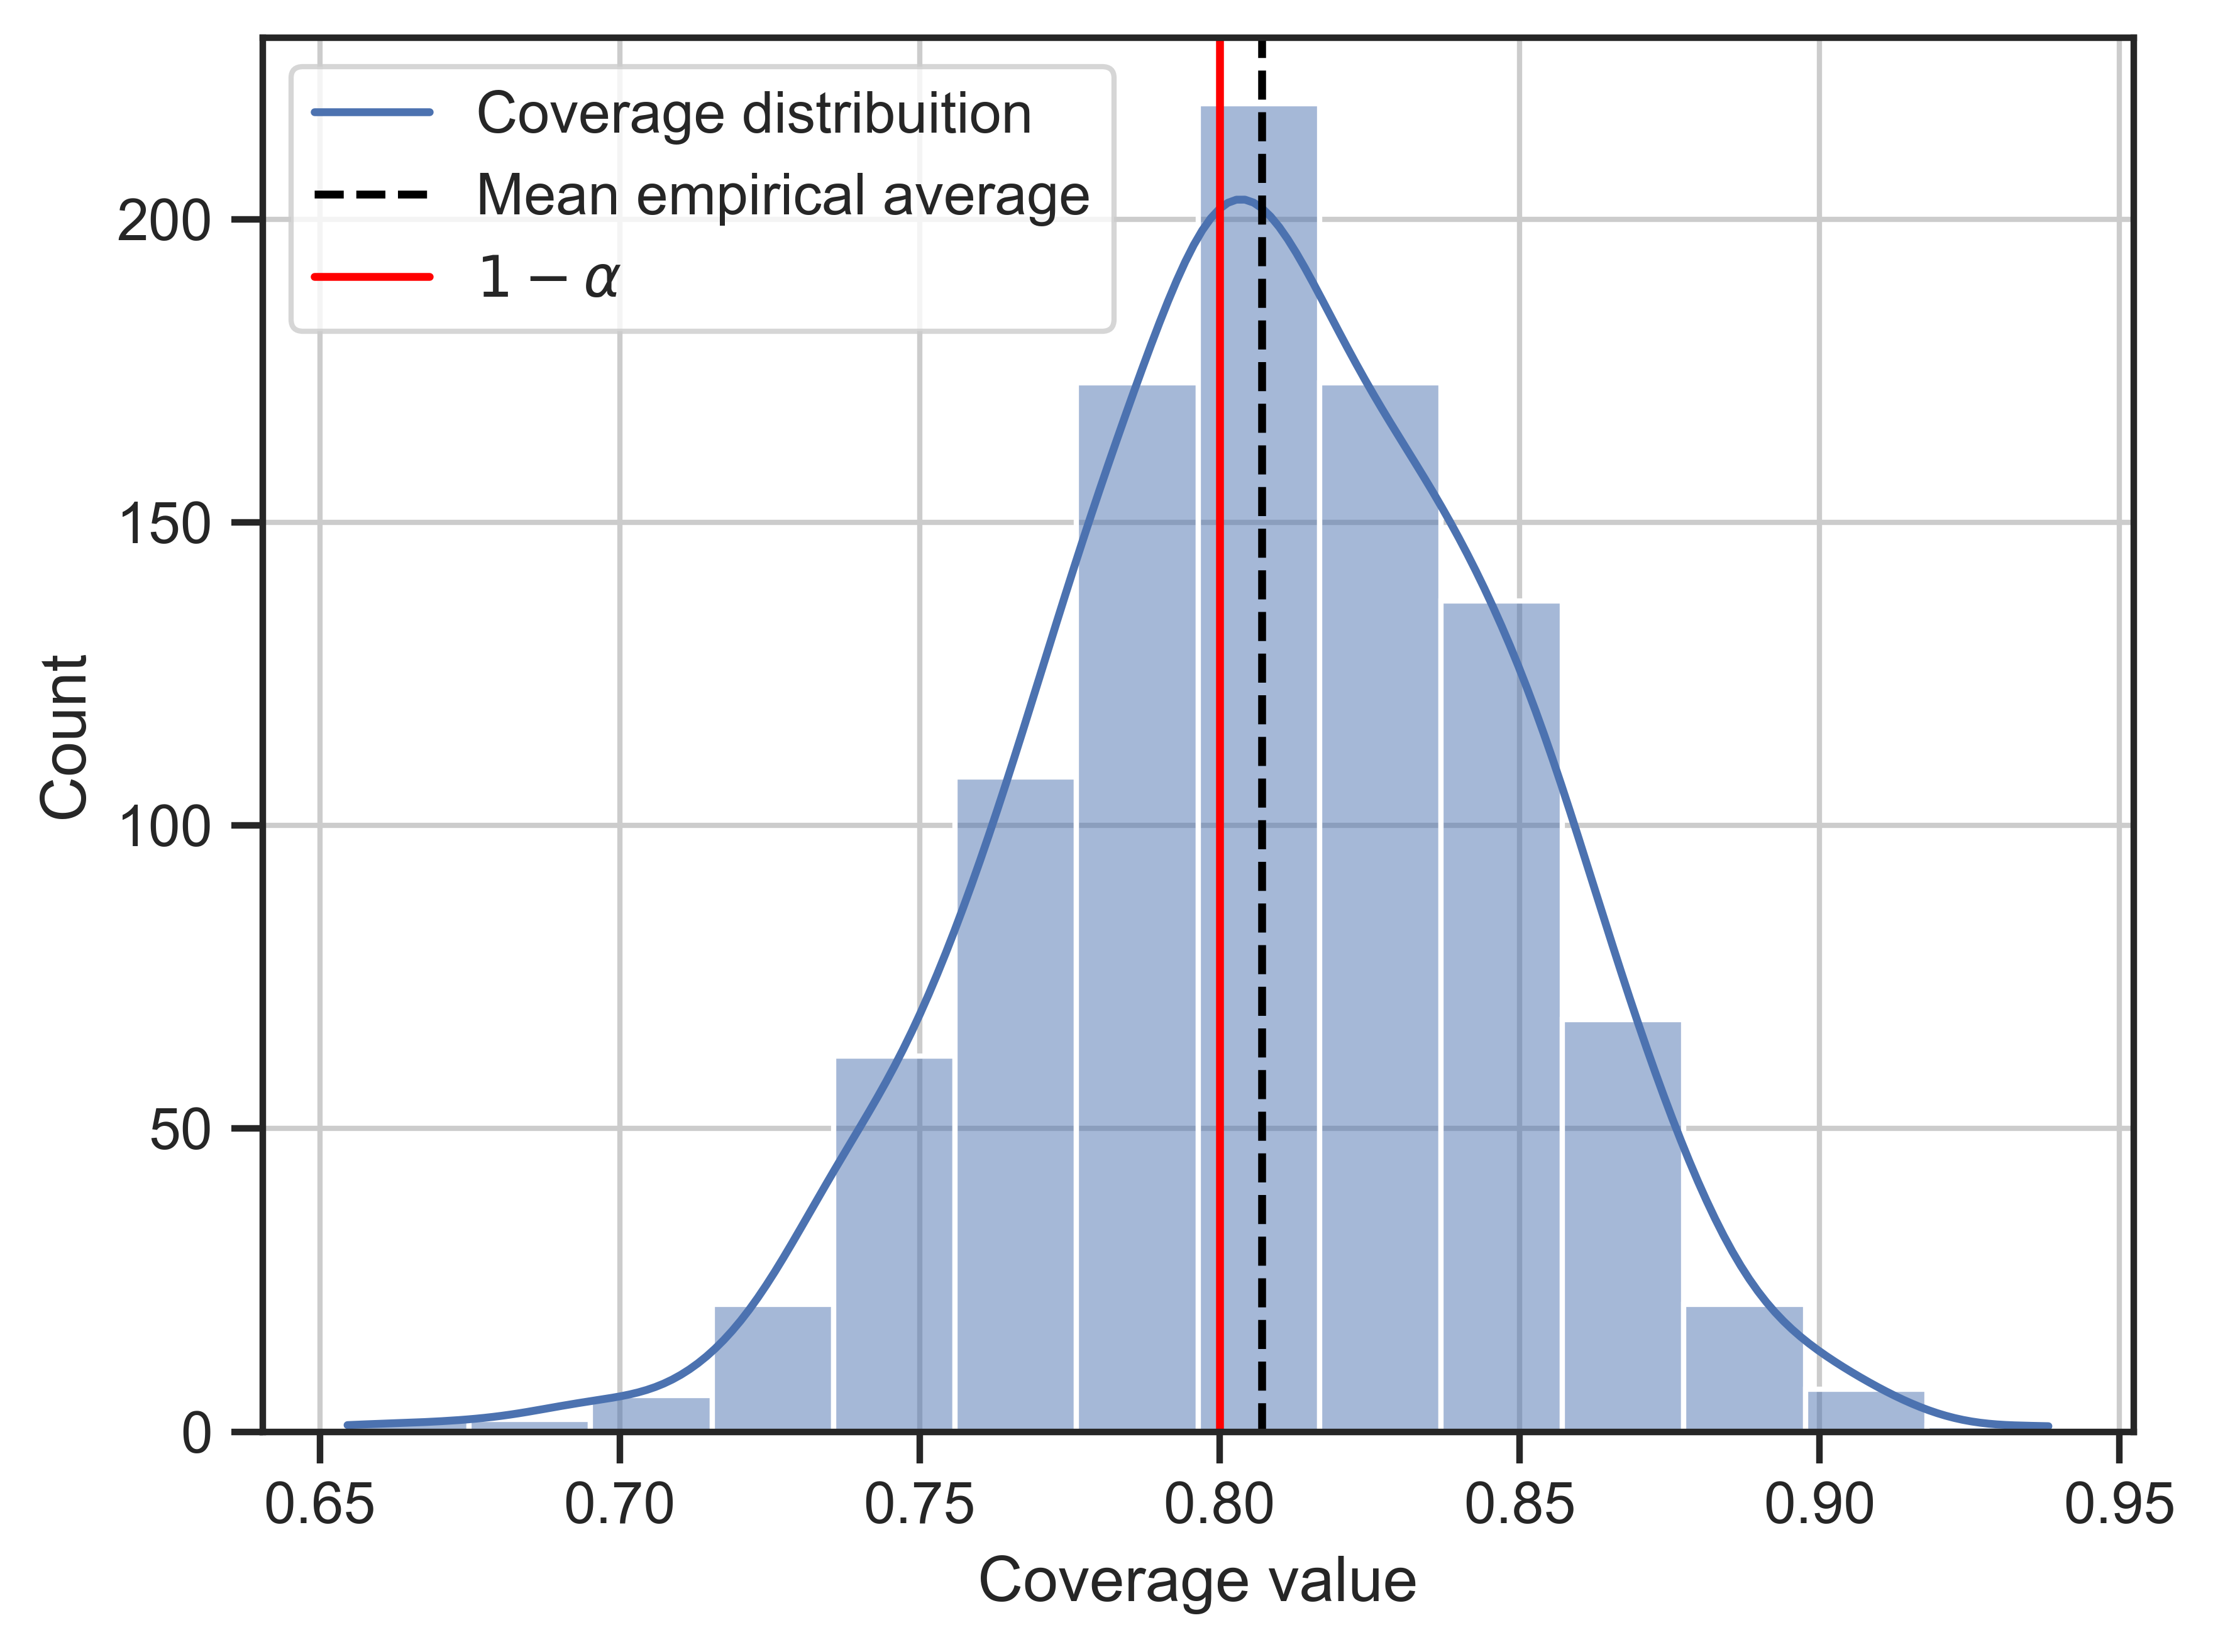

In [84]:
import seaborn as sns
sns.set(style="ticks")
plt.figure(dpi=600)

bins = np.linspace(min(final_empirical_coverage), max(final_empirical_coverage), 15)
sns.histplot(np.array(final_empirical_coverage), kde=True, bins=bins)
# plt.title(f'Histogram of The Empirical coverage after {r} runs')
plt.axvline(x = 0.807, color = 'black', linestyle='dashed')
plt.axvline(x = 0.8, color = 'red', linestyle = 'solid')
plt.legend(['Coverage distribuition','Mean empirical average', r'$1-\alpha$'])
plt.xlabel('Coverage value')
plt.grid()
plt.savefig('Empirical_Coverage_dist_1000_runs_alpha_0.2_mymodel_final_testing_196calpoints.pdf', format='pdf', dpi=600)

# Evaluation of the three methods